<a href="https://colab.research.google.com/github/ghadee3r/Afaq-DataScience/blob/main/Afaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Afaq - آفاق

Afaq is designed to promote tourism in Saudi Arabia by analyzing engagement with photos. To collect data, we utilize Flickr’s API, applying specific queries to retrieve images and it's data that are relevant to our study.

Additionally, we analyze the images themselves to identify features that contribute to higher engagement, helping us understand what captures viewers’ attention. Data collection began on January 25, 2025, and continues to capture seasonal trends and evolving viewer preferences.

## Import required libraries:

To keep the notebook clean, we suppress unnecessary installation logs and warnings.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

This section installs the **OpenAI CLIP** model, which will be used for **image classification**.  

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git
import clip
import torch
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

  Preparing metadata (setup.py) ... done


This section installs the **Transformers** model, which will be used for **text classification**.  


In [ ]:
!pip install -q transformers torch arabic-reshaper python-bidi camel-tools nltk textblob
from transformers import pipeline

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
No module named 'numpy.char'

we will import all other libraries that we need.

In [ ]:
import json
import requests
from IPython.display import display, Image  # For displaying images
import os
import numpy as np
from PIL import Image as PILImage
from io import BytesIO
from datetime import datetime
import cv2
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

## Setting up Flickr API Data:

This section outlines the important steps for setting up the Flickr API. It includes creating an instance of the API, defining the API URL and required parameters, processing the initial response data, and extracting key variables from the API response. We will assign these variables to separate categories for further analysis and then organize them in a structured format, to facilitate subsequent data processing and insights extraction related to photo posts.

In [ ]:
# Our Flickr API key
api_key = "7e02e554596c0df3b61a14dd183fcea9"
# Flickr API endpoint
url = "https://www.flickr.com/services/rest/"

This dictionary, photo_ids, is structured to categorize photo IDs based on geographical regions in Saudi Arabia. Each region (North, East, Central, West, and South) serves as a key, and the corresponding list of photo IDs represents images associated with that region.

In [ ]:
# Dictionary to categorize photos based on region
photo_ids = {
     "North": [
        "39575502374", "39085330295" ,  "53318266559", "8293803689", "52161445956",
        "51415556417", "25226378093", "25368882276", "7915194374","12843910963",
        "5246743263", "3194213739", "6193493660", "13099697553","7454028920",
        "8156012786", "7053175151", "5042956322", "30136168240", "18928927890" ,
        "21080979226", "5598311062", "9094180505", "9628730978","37404960322",
        "5936744596", "6531702859", "7431468572", "8450401507", "6581570777",
        "17966285606", "6776442927", "7942255916", "8408057055", "8480072900",
        "6608611027", "8285091660", "46405853415", "41939149250", "4086211492"
    ],
    "East": [
        "19857167211", "9622141614", "5509244934", "3271688714", "54234462054",
        "49565660947", "4354065461", "4392235957", "46899502932", "7169528998",
        "8613545774", "15348768023", "9202704289", "28059167439","5033753132",
        "3384438555", "5206980943", "6935538637", "9478115449", "5191613099",
        "14854273239", "8242908309", "3078982619", "5319643016", "7314875622",
        "8733415670", "4951132298", "8432459662", "5902913932", "4187821453",
        "4188593520", "3273177054", "50292527132", "51388082825", "8648618463",
        "50518075541", "23726360325", "23304092284", "27899891165", "3078982619"
    ],
    "Central": [
       "7421302032", "54138387300", "4544061049", "52749372830", "52752496752" ,
       "27301404259", "53504590533", "32215905732", "49015092862", "26946151761",
       "4160508524", "9960182394", "23392200464", "53586614288", "24920025196" ,
       "25885494278", "50671612843", "53537327505", "51419529352", "52734351298",
      "30505683513", "52742538111", "22773525798", "30006550976", "15256538221",
      "33324046215", "52751122599", "36584720163", "46625047862", "5102482472",
      "11432341654", "52726469383", "53138715748", "48768184901", "3498810366" ,
      "51022288913", "49217114598", "28647702697", "54233509161", "3267616846"

    ],
    "West": [
        "49756506966", "53026138379", "52992976643", "4415788252", "4415785888",
        "53025608447", "50772373147", "54245535256", "54238968122", "54240279835",
        "6848359467", "48329379352", "11249682613", "35073372902", "19785645783",
        "51035658763", "14503214808", "14503414707", "44066599842", "9800608446",
        "52692317564", "52699697936", "43314356205", "29345654457", "51844356244",
        "45148226335", "43100632905", "32591471447", "52699697936", "39493394652",
        "10831981074", "39624818180", "6994363430", "44691506321", "4170907051",
        "25467688148", "7329746082", "52670628931", "43211069192", "15434286176"
    ],
    "South": [
        "51186733714", "7171364806", "36188438912", "7307886154", "51225607587",
        "51228504040", "29055820201", "20382216075", "42879002475", "6198889223",
        "9305523960", "3323584085", "22615942988", "49586007781", "15844527591",
        "15399758757", "49585702448", "49586208876", "49586007781", "2132542371",
        "26903039282", "4948686527", "28266002176", "6109470685", "29710151296",
        "7309281642", "8336447619", "14131738933", "8272412049", "8623038624",
        "5495001603", "4597920799", "8308103019", "18267251386", "6184718045",
        "14648926871", "8168309568", "385777304", "49408320836", "49408321981"
    ]
}


## Saving Raw Data in a File

This code utilizes the Flickr API to retrieve raw data for specific photos using three methods:
- `flickr.photos.getFavorites` to determine a photo’s popularity based on the number of favorites.  
- `flickr.photos.getInfo` to obtain metadata.
- `flickr.photos.comments.getList` to fetch user comments associated with the photo.  

The `fetch_flickr_data` function makes API requests and returns the response in JSON format. Then the collected data is saved to a JSON file (`afaq_data.json`).

In [ ]:

def fetch_flickr_data(method, photo_id):
    params = {
        "method": method,
        "api_key": api_key,
        "photo_id": photo_id,
        "format": "json",
        "nojsoncallback": 1
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()  # Return JSON data as a dictionary
    else:
        print(f"Failed to fetch data for photo ID {photo_id}: {response.status_code} - {response.text}")
        return None

# Save raw data as JSON
output_data = {}

for region, ids in photo_ids.items():
    output_data[region] = {}
    for photo_id in ids:
        output_data[region][photo_id] = {}

        # Fetch favorites
        favorites_data = fetch_flickr_data("flickr.photos.getFavorites", photo_id)
        if favorites_data:
            output_data[region][photo_id]["favorites"] = favorites_data

        # Fetch info
        info_data = fetch_flickr_data("flickr.photos.getInfo", photo_id)
        if info_data:
            output_data[region][photo_id]["info"] = info_data

        # Fetch comments
        comments_data = fetch_flickr_data("flickr.photos.comments.getList", photo_id)
        if comments_data:
            output_data[region][photo_id]["comments"] = comments_data

# Save to JSON file
with open("Afaq_RawData.json", "w", encoding="utf-8") as file:
    json.dump(output_data, file, indent=4, ensure_ascii=False)

print("Data successfully saved to afaq_data.json")

KeyboardInterrupt: 

## Required Functions

In this section, we will implement customized functions to effectively organize and process the data fetched from Flickr, ensuring the dataset is organized and ready for analysis.

This function constructs the image URL using the photo's metadata (farm ID, server ID, photo ID, and secret) to retrieve the image itself.
The function follows Flickr’s standard URL format and returns the largest available image size (denoted by _b.jpg for "big" resolution). If the original size is unavailable, this URL ensures a high-quality fallback.

In [ ]:
# Construct the image URL
def construct_image_url(photo):
    farm_id = photo["farm"]  # Indented this line
    server_id = photo["server"]  # Indented this line
    photo_id = photo["id"]  # Indented this line
    secret = photo["secret"]  # Indented this line

    # Use the URL format for the original size, fallback to large size if unavailable
    return f"https://farm{farm_id}.staticflickr.com/{server_id}/{photo_id}_{secret}_b.jpg"


The following code utilizes a Flickr API service method (flickr.photos.getFavorites) that retrieves a list of users who have favorited a particular image. By counting the number of users in this list, we can estimate the popularity of the image based on the number of times it has been favorited.

Since Flickr paginates API responses (meaning that not all favorites are returned in a single request), the function uses pagination to request additional pages until all favorites are counted.

In [ ]:
# Function to count the number of people who favorited the photo with pagination
def count_favorites(api_key, photo_id):
    total_count = 0
    page = 1

    while True:
        params = {
            "method": "flickr.photos.getFavorites", #This method is a Flickr API service that returns a list of people who favorited the photo
            "api_key": api_key,
            "photo_id": photo_id,
            "format": "json",
            "nojsoncallback": 1,
            "page": page,
            "per_page": 50  # Max number of results per page
        }
        response = requests.get(url, params=params)
        data = response.json()

        if data.get("stat") != "ok":
            return f"Error: {data.get('message', 'Unknown error')}"

        # Add the count of people on this page
        total_count += len(data["photo"]["person"])

        # Check if we need to fetch the next page
        if page >= data["photo"]["pages"]:
            break
        page += 1

    return total_count

This function retrieves all comments associated with a specific Flickr photo using the Flickr API method flickr.photos.comments.getList. It allows us to extract user-generated comments on an image, providing insights into user engagement and reactions.

In [ ]:
# Function to retrieve comments on a photo
def get_photo_comments(api_key, photo_id):
    params = {
        "method": "flickr.photos.comments.getList",
        "api_key": api_key,
        "photo_id": photo_id,
        "format": "json",
        "nojsoncallback": 1
    }
    response = requests.get(url, params=params)
    data = response.json()

    if data.get("stat") != "ok":
        return f"Error: {data.get('message', 'Unknown error')}"

    # Extract comments
    comments_data = data.get("comments", {}).get("comment", [])
    comments = []
    for comment in comments_data:
        comments.append(comment["_content"])

    return comments

This function performs sentiment analysis on comments using a pre-trained model from Hugging Face (cardiffnlp/twitter-xlm-roberta-base-sentiment). It initializes a sentiment analysis pipeline, processes a list of comments, and assigns a sentiment label (e.g., positive, negative, or neutral). The function returns a structured list pairing each comment with its sentiment, allowing for further analysis of user engagement and feedback trends.

In [ ]:
def classify_comments(comments):
    sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", truncation=True)
    sentiments = sentiment_pipeline(comments, max_length=512)  # Added max_length
    return [{"text": text, "sentiment": result["label"]} for text, result in zip(comments, sentiments)]

This function calculates a sentiment score based on classified comments. It takes a list of comments where each comment includes text and a sentiment label (positive, negative, or neutral). The function iterates through the comments and assigns numerical values:

+1 for positive comments
-1 for negative comments
0 for neutral comments
The final sentiment score reflects the overall sentiment trend of the comments, helping to gauge whether the feedback is generally positive, negative, or neutral.

In [ ]:
def calculate_sentiment_score(classified_comments):
    score = 0

    for comment in classified_comments:
        # Assume each comment is structured like [{'text': '...', 'sentiment': '...'}]
        sentiment = comment[0]['sentiment']  # Extract the sentiment of the first element

        if sentiment == 'positive':
            score += 1
        elif sentiment == 'negative':
            score -= 1
        elif sentiment == 'neutral':
            score += 0  # Neutral has no effect on the score

    return score

This function classifies the type of region ("beach", "city", "historical site", "nature", "desert") based on the content of the image itself. Using OpenAI's CLIP model, the function compares the image with predefined region categories and determines the best match based on visual features.






In [ ]:
def classify_region(image_url):
    try:

        # Download image
        response = requests.get(image_url)
        if response.status_code == 200:
            image = PILImage.open(BytesIO(response.content)).convert("RGB")
        else:
            print("Error: Could not download image")
            return "Unknown"

        # Preprocess the image
        image = preprocess(image).unsqueeze(0).to(device)

        # Define categories for classification
        categories = ["coastal", "urban", "historical site", "nature", "desert"]

        # Convert text labels to embeddings
        text_inputs = clip.tokenize(categories).to(device)

        # Predict using CLIP
        with torch.no_grad():
            image_features = model.encode_image(image).float()
            text_features = model.encode_text(text_inputs).float()

            # Normalize the features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Compute similarity scores
            similarity = (image_features @ text_features.T).softmax(dim=-1)
            best_match = categories[similarity.argmax().item()]

        return best_match

    except Exception as e:
        print(f"Error processing image: {e}")
        return "Unknown"


Similar to the code above, this function extracts key visual elements (e.g., sky, trees, buildings) from the photos themselves, identifying multiple objects or features present in the image.
Instead of classifying the overall scene (such as "beach" or "city"), this function detects specific visual components, providing a detailed breakdown of what appears in the image. It uses OpenAI's CLIP model to compare the image with a predefined set of visual elements and returns the top matches.

In [ ]:
def extract_visual_elements(image_url):
    try:

        # Download the image
        response = requests.get(image_url)
        if response.status_code == 200:
            image = PILImage.open(BytesIO(response.content)).convert("RGB")
        else:
            print("Error: Could not download image")
            return "Unknown"

        # Preprocess the image
        image = preprocess(image).unsqueeze(0).to(device)

        # Define common **visual elements** categories
        visual_elements = [
            "sky", "water", "mountains", "buildings", "trees",
            "cars", "people", "animals", "sand", "grass",
            "clouds", "sun", "moon", "boats", "roads",
            "flowers", "statues", "rocks", "mosques", "snow"
        ]

        # Convert text labels to embeddings
        text_inputs = clip.tokenize(visual_elements).to(device)

        # Predict using CLIP
        with torch.no_grad():
            image_features = model.encode_image(image).float()
            text_features = model.encode_text(text_inputs).float()

            # Normalize the features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Compute similarity scores
            similarity = (image_features @ text_features.T).softmax(dim=-1)

            # Get top 3 visual elements
            top_indices = similarity[0].topk(3).indices.tolist()
            best_matches = [visual_elements[i] for i in top_indices]

        return best_matches

    except Exception as e:
        print(f"Error extracting visual elements: {e}")
        return "Unknown"


This function extracts key visual elements from an image and returns the total number of detected elements, representing the variety of objects or features present.

In [ ]:
def count_total_visual_elements(image_url):
    try:
        # Extract elements first
        detected_elements = extract_visual_elements(image_url)
        if not detected_elements:
            return 0  # No elements detected

        # Count the total number of detected elements
        total_count = len(detected_elements)

        return total_count

    except Exception as e:
        print(f"Error counting visual elements: {e}")
        return 0

        return 0  # Return 0 in case of an error



This function retrieves key details about a photo using its unique ID via the Flickr API. It extracts information such as the title, views, favorites count, comments, date taken, date uploaded, location, and a direct image URL. By gathering this metadata, the function helps analyze image popularity, user engagement, and regional relevance. This data can be useful for understanding tourism trends, content impact, and visual analysis.

In [ ]:
def get_photo_details(api_key, photo_id):
    params = {
        "method": "flickr.photos.getInfo",  # This method is a Flickr API service that returns photo info based on its ID
        "api_key": api_key,
        "photo_id": photo_id,
        "format": "json",
        "nojsoncallback": 1
    }
    response = requests.get(url, params=params)
    data = response.json()

    if data.get("stat") != "ok":
        return f"Error: {data.get('message', 'Unknown error')}"

    # Extracting required details
    photo = data["photo"]
    date_taken = photo["dates"]["taken"]
    date_uploaded = photo["dates"]["posted"]
    title = photo["title"]["_content"]
    views = photo["views"]
    comments_count = photo["comments"]["_content"]
    comments = get_photo_comments(api_key, photo_id)  # Retrieve the comments

    # Store the view count for normalization
    Normalization(photo_id, views)

    # Get the image URL
    image_url = construct_image_url(photo)

    return image_url, title, views, count_favorites(api_key, photo_id), comments_count, comments, date_uploaded, date_taken

This function stores the views of each photo inside an array.

In [ ]:
# Global dictionary to store photo views
photo_views = {}

def Normalization(photo_id, views):
    """Store views count in a dictionary for each photo."""
    photo_views[photo_id] = int(views)  # Convert views to an integer if not already

The following function returns the region name associated with a given photo ID, based on the array of regions where each region contains an array of photo IDs.

In [ ]:
def get_region(photo_id):
    for region_name, photo_list in photo_ids.items():
        if photo_id in photo_list:
            return region_name

Here we define a function, classify_image_time_of_day(image_url), which determines if an image represents daytime or nighttime based on its brightness.
It processes the image using OpenCV’s cv2.IMREAD_GRAYSCALE model, which converts the image to grayscale for analysis. The function calculates the average brightness and classifies the image as "Day" if the value is above 50; otherwise, it returns "Night".

In [ ]:
def classify_image_time_of_day(image_url):
    try:
        # Download the image content
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad responses

        # Read the image content using OpenCV
        image = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale

        # Check if image loading was successful
        if image is None:
            print(f"Error: Could not load image from {image_url}")
            return "Unknown"  # Default if image cannot be processed

        avg_brightness = np.mean(image)  # Compute average brightness

        # Classify based on brightness threshold
        return "Day" if avg_brightness >= 50 else "Night"

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return "Unknown"  # Return Unknown if download fails

    except Exception as e:
        print(f"Error processing image: {e}")
        return "Unknown"

The following code is a function that displays photos when needed using the image URL fetched from flickr.

In [ ]:
def display_image(image_url):
    try:
        response = requests.get(image_url)
        img = PILImage.open(BytesIO(response.content))
        display(img)  # Display the image in a Jupyter notebook
    except Exception as e:
        print("Error displaying image:", e)

## Data Processing and Cleaning

#### Transofrmation
This function determines the season of a photo based on date_taken attribute retrieved from the Flickr API. It transforms the date string into a datetime object, extracts the month and day, and assigns the photo to Winter, Spring, Summer, or Autumn using predefined date ranges

In [ ]:
def get_season(date_taken):
    date_obj = datetime.strptime(date_taken, "%Y-%m-%d %H:%M:%S")
    month = date_obj.month
    day = date_obj.day

    if (month == 12 and day >= 15) or (month in [1, 2]) or (month == 3 and day < 15):
        return "Winter"
    elif (month == 3 and day >= 15) or (month in [4, 5]) or (month == 6 and day < 15):
        return "Spring"
    elif (month == 6 and day >= 15) or (month in [7, 8]) or (month == 9 and day < 15):
        return "Summer"
    else:
        return "Autumn"

#### Normalization
This function standardizes the "views" attribute using Z-score normalization, which scales values based on their deviation from the mean. It helps handle outliers and ensures values have a mean of 0 and a standard deviation of 1.

In [ ]:
def normalize_views_zscore():
    """Normalize the view counts using z-score normalization."""
    if not photo_views:
        return {}

    views_array = np.array(list(photo_views.values()), dtype=float)
    mean_views = views_array.mean()
    std_views = views_array.std()

    # Avoid division by zero if standard deviation is 0
    if std_views == 0:
        normalized_views = {pid: 0.0 for pid in photo_views}  # All views are the same, so z-score is 0
    else:
        normalized_views = {
            pid: (float(views) - mean_views) / std_views  # Convert 'views' to float for calculation
            for pid, views in photo_views.items()
        }

    return normalized_views

#### Standarization
This function standardizes a Unix timestamp into a human-readable date format. It takes a numerical timestamp, converts it into a datetime object, and formats it as YYYY-MM-DD HH:MM:SS. By transforming raw timestamps into structured date representations.

In [ ]:
def standardize_date(date_uploaded):

    dt_object = datetime.fromtimestamp(int(date_uploaded))

    return dt_object.strftime("%Y-%m-%d %H:%M:%S")

### Encoding
These four functions, converts categorical string inputs into numerical values using predefined dictionaries. The `encode_season` encodes a given season name into a corresponding numerical value. It uses a dictionary, season_mapping, where each season is assigned a unique integer. When the function is called with a season as input, it retrieves the corresponding encoded value from the dictionary and returns it.

Similiaraly, The `encode_time_of_day`  maps "Day" to 0 and "Night" to 1. The `encode_region_type` assigns numbers to regions: "North" as 0, "South" as 1, "Central" as 2, "East" as 3, and "West" as 4. The `encode_landscape_type` converts landscape types such as "coastal" to 0, "urban" to 1, "historical site" to 2, "nature" to 3, and "desert" to 4.

In [ ]:
def encode_season(season):

    season_mapping = {
        "Winter": 1,
        "Spring": 2,
        "Summer": 3,
        "Autumn": 4
    }

    return season_mapping[season]

In [ ]:
def encode_time_of_day(time_of_day):

    time_mapping = {
        "Day": 0,
        "Night": 1
    }

    return time_mapping[time_of_day]

In [ ]:
def encode_region_type(region):

    region_mapping = {
        "North": 0,
        "South": 1,
        "Central": 2,
        "East":3,
        "West":4
    }

    return region_mapping[region]

In [ ]:
def encode_landscape_type(landscape_type):

    landscape_mapping = {
        "coastal": 0,
        "urban": 1,
        "historical site": 2,
        "nature":3,
        "desert":4
    }

    return landscape_mapping[landscape_type]

## Saving Data in a file

To perform EDA we will save data in a file

In [ ]:
# First, collect all photo views before normalization
for region_name, photo_list in photo_ids.items():
    for photo_id in photo_list:
        get_photo_details(api_key, photo_id)  # Collect views for normalization

# Normalize all collected view counts
normalized_views = normalize_views_zscore()

# Define CSV file name
Afaq_Processed = "Afaq_Processed.csv"

# Define column headers
columns = [
    "Photo ID", "Title", "Favorites Count", "Normalized View Count", "Comments Count",
    "Sentiment Score", "Date Uploaded", "Season", "Time of Day",
    "Region", "Landscape Type", "Visual Elements", "Elements Count"
]

# Open the CSV file and write data row by row
with open(Afaq_Processed, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(columns)  # Write header

    for region_name, photo_list in photo_ids.items():
        for photo_id in photo_list:
            photo_details = get_photo_details(api_key, photo_id)

            if isinstance(photo_details, tuple):
                image_url, title, views, favorites_count, comments_count, comments, date_uploaded, date_taken = photo_details

                # Extract visual elements and region type
                region = get_region(photo_id)
                landscape_type = classify_region(image_url)
                visual_elements = extract_visual_elements(image_url)
                element_count = count_total_visual_elements(image_url)

                # Classify each comment and store the results
                classified_comments = [classify_comments(comment) for comment in comments]

                # Calculate sentiment score based on classified comments
                sentiment_score = calculate_sentiment_score(classified_comments)

                # Determine season
                season = get_season(date_taken)

                # Determine time of day
                time_of_day = classify_image_time_of_day(image_url)

                # Standardize date
                date_uploaded = standardize_date(date_uploaded)

                # Retrieve normalized view count from the dictionary
                normalized_value = normalized_views.get(photo_id, 0.0)  # Ensure normalized views exist

                # Encode season and time and landscape
                season = encode_season(season)
                time_of_day = encode_time_of_day(time_of_day)
                region = encode_region_type(region)
                landscape_type = encode_landscape_type(landscape_type)

                # Write row directly to CSV file
                writer.writerow([
                    photo_id, title, favorites_count, normalized_value, comments_count,
                    sentiment_score, date_uploaded, season, time_of_day,
                    region, landscape_type, ", ".join(visual_elements), element_count
                ])

print(f"CSV file '{Afaq_Processed}' has been saved successfully.")

## Exploratory Data Analysis (EDA)



Performing EDA on the dataset to explore its structure, identify patterns, and gain insights. This includes statistical summaries, visualizations, and correlation analysis.

#### Metadata Review:
- Source of Data: The dataset is derived from Flickr API, meaning that all images and engagement metrics are user-generated and reflect public interactions on the platform.
- Date Collected: The dataset encompasses data from multiple years, allowing for the analysis of temporal trends in engagement metrics such as favorites, views, and comments. However, our own data collection process officially commenced on January 25, 2025.
- Collection Method: The data was obtained via the Flickr API, which inherently selects publicly shared images and excludes private or restricted content. The model focuses on landscape photos relevant to Saudi Arabia.
- Accompanying Metadata, Each image includes:
  - Engagement Metrics: Number of favorites, comments, and views.
Visual Elements: Detected objects or themes in photos (e.g., mosques, buildings, mountains, water).
  - Geographic Data: The region where the photo was taken (mapped to 5 different regions of Saudi Arabia).
  - Temporal Data: Year and time of day when the image was uploaded.
  - Sentiment Analysis: Based on the text of comments, indicating positive, neutral, or negative reception.

#### Bias Awareness:
- Platform Bias: Since the data is sourced from Flickr, it reflects only users who actively upload landscape photos to this platform. Tourists and professional photographers may be overrepresented compared to local residents.
- Engagement Bias: Some photos receive significantly higher favorites and comments, creating outliers that may skew analysis.
- Regional Bias: The dataset shows unequal representation of different regions in Saudi Arabia. For example:
  - Mosques, buildings, and roads appear frequently, indicating a concentration of urban photos.
  - Desert and historical sites are prominent in specific regions, while others (e.g., coastal attractions) may be underrepresented.
- Temporal Bias:
There are fluctuations in engagement over time, with spikes in specific years.
Time of day analysis shows that certain periods may receive more engagement, but this could be influenced by Flickr’s recommendation algorithms rather than actual tourist activity.
- Tourist Preference Bias: High engagement (favorites, views, comments) does not necessarily indicate a location’s actual attractiveness — it may be influenced by photo quality, social media trends, or specific photographers with large followings.
- Data Exclusion Bias: Since only publicly available photos are included, any private collections or restricted content (e.g., government-protected areas) are missing from the dataset.

### Read file

First, we will read the file to load the dataset into a DataFrame. This will allow us to perform (EDA) and better understand the structure and contents of the data.

In [ ]:
Afaq_processed = pd.read_csv('Afaq_Processed.csv', encoding='latin1') #Load the dataframe

### Calculating Popularity Score


In this step, we calculate the Popularity Score for each photo to measure how engaging it is relative to how often it was viewed.

We used the normalized view count (scaled to 0–1) as a proxy for actual visibility. To avoid dividing by small or negative values, and to reflect both interaction and audience sentiment, we used the following formula:

**Popularity Score = ((Favorites Count + Comments Count) / (1 + Normalized View Count (0–1))) * (1 + Sentiment Score)**

This formula considers:
- **Interaction**: the total of favorites and comments.
- **Visibility**: represented by the normalized view count.
- **Public sentiment**: captured through the sentiment score.

This way, we not only evaluate how frequently users interacted with a photo relative to its visibility, but also boost the score for photos that received more positive feedback.

After calculating the score, we saved the updated data back to the same file.




In [ ]:
min_val = Afaq_processed["Normalized View Count"].min()
max_val = Afaq_processed["Normalized View Count"].max()

Afaq_processed["Normalized View Count (0-1)"] = (
    (Afaq_processed["Normalized View Count"] - min_val) / (max_val - min_val)
)


Afaq_processed["Popularity Score"] = (
    (Afaq_processed["Favorites Count"] + (Afaq_processed["Comments Count"]  *(1+Afaq_processed["Sentiment Score"])))) / (1 + Afaq_processed["Normalized View Count (0-1)"]
)



Afaq_processed.to_csv("Afaq_EDA.csv", index=False)

Afaq_processed[[
    "Photo ID", "Favorites Count", "Comments Count",
    "Normalized View Count", "Normalized View Count (0-1)",
    "Sentiment Score", "Popularity Score"
]].head()

,Photo ID,Favorites Count,Comments Count,Normalized View Count,Normalized View Count (0-1),Sentiment Score,Popularity Score
0,39575502374,24,4,-0.059892,0.059563,2,33.976273
1,39085330295,12,0,-0.342217,0.028890,0,11.663052
2,53318266559,189,15,0.625359,0.134011,10,312.166330
3,8293803689,12,19,-0.373752,0.025464,19,382.265926
4,52161445956,262,16,1.166571,0.192810,14,420.855008


### Checking for Missing Data  
Identifying and assessing missing values in the dataset to ensure data completeness and reliability.

In [ ]:
missing_values = Afaq_processed.isnull().sum()  # Count missing values per column
total_missing = missing_values.sum()  # Total missing values in the dataset

if total_missing == 0:
    print("No missing values found in the dataset!")
else:
    print("Missing values detected!")
    print(missing_values[missing_values > 0])  # Display only columns with missing values

Missing values detected!
Title    1
dtype: int64


We identified **one missing value in the "Title" column**, which does not significantly impact our analysis since engagement metrics and metadata remain intact.

### Removing irrelevant Attributes

In [ ]:
Afaq_processed = Afaq_processed.drop(columns=['Title'])
Afaq_processed.to_csv("Afaq_processed.csv", index=False)

The 'Title' attribute has been found to provide little to no functional benefit in our implementation. It does not affect our analysis meaningfully. Therefore, we have decided to remove the Title attribute across all applicable elements.

### Readability & Interpretability
We removed the numerical encoding to improve **readability and interpretability** in our analysis. Using actual names (e.g., For Regions: *North, East, Central, West, South*) instead of numerical codes makes it easier to understand trends, compare statistics, and create clear visualizations. This ensures that insights are more accessible and meaningful, especially for stakeholders who may not be familiar with the encoding system.

Ideally, we could have used actual data names from the beginning instead of encoding them. However, since our dataset includes image processing, which is computationally expensive and time-consuming, we performed all necessary processing steps first to avoid reprocessing the entire file multiple times. This approach ensures efficiency while still allowing us to make the dataset more readable for analysis and visualization.

In [ ]:
missing_values = Afaq_processed.isnull().sum()  # Count missing values per column
total_missing = missing_values.sum()  # Total missing values in the dataset

if total_missing == 0:
    print("No missing values found in the dataset!")
else:
    print("Missing values detected!")
    print(missing_values[missing_values > 0])  # Display only columns with missing values

No missing values found in the dataset!


In [ ]:
# Dictionary to map encoded region values to actual region names
region_mapping = {
    0: "North",
    1: "South",
    2: "Central",
    3: "East",
    4: "West"
}

# Dictionary to map encoded time of day values to actual time names
time_mapping = {
    0: "Day",
    1: "Night"
}

# Dictionary to map encoded season values to actual season names
season_mapping = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Autumn"
}

# Dictionary to map encoded landscape values to actual landscape types
landscape_mapping = {
    0: "Coastal",
    1: "Urban",
    2: "Historical Site",
    3: "Nature",
    4: "Desert"
}

# Apply the mappings to the corresponding columns
Afaq_processed["Region"] = Afaq_processed["Region"].map(region_mapping)
Afaq_processed["Time of Day"] = Afaq_processed["Time of Day"].map(time_mapping)
Afaq_processed["Season"] = Afaq_processed["Season"].map(season_mapping)
Afaq_processed["Landscape Type"] = Afaq_processed["Landscape Type"].map(landscape_mapping)


### Statistical Summary  

Generating basic statistics such as mean, median, minimum, maximum, and other descriptive metrics to understand the distribution of the data.

In [ ]:
# Get the statistical summary of numerical columns
Afaq_EDA = pd.read_csv("Afaq_EDA.csv")
Afaq_filtered = Afaq_EDA.drop(columns=["Photo ID"])
summary = Afaq_filtered.describe()

# Print the summary
print("Statistical Summary:\n")
display(summary)

Statistical Summary:



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.0,199.000000,199.000000
mean,51.045226,0.014418,17.361809,10.462312,2.321608,0.140704,1.994975,2.371859,3.0,0.067636,592.176684
std,98.038814,1.015936,30.880836,17.268449,1.217335,0.348592,1.419551,1.397115,0.0,0.110375,1651.008054
min,0.000000,-0.608135,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.0,0.000000,0.000000
25%,4.000000,-0.454508,0.000000,0.000000,1.000000,0.000000,1.000000,1.500000,3.0,0.016691,6.349304
50%,15.000000,-0.295553,5.000000,3.000000,2.000000,0.000000,2.000000,2.000000,3.0,0.033960,47.420346
75%,43.000000,0.028215,19.000000,13.000000,3.500000,0.000000,3.000000,4.000000,3.0,0.069135,302.662921
max,595.000000,8.596303,206.000000,84.000000,4.000000,1.000000,4.000000,4.000000,3.0,1.000000,13065.597086


The statistical summary describes the dataset. Favorites Count ranges from 0 to 595, with an average of 51, showing some photos are popular than others. Normalized View Count and Comments Count vary widely, with comments reaching up to 206. The Sentiment Score ranges from 0 to 84, with an average of 10, different levels of user feedback.
The Elements Count, remains consistent. The Year Uploaded spans from 2007 to 2025, with more uploaded around 2015.

This will output five different tables, each summarizing the numerical features for a specific region.

In [ ]:
# Get unique regions
unique_regions = Afaq_filtered["Region"].unique()
# Generate descriptive statistics for each region and display separately
for region in unique_regions:
    print(f"Statistical Summary for Region: {region}\n")
    display(Afaq_filtered[Afaq_filtered["Region"] == region].describe())
    print("\n" + "="*80 + "\n")  # Separator for better readability


Statistical Summary for Region: 0



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.0,40.000000,40.0,40.000000,40.000000
mean,49.100000,0.078330,24.975000,15.625000,2.250000,0.15000,0.0,3.100000,3.0,0.074580,871.287013
std,75.024372,0.622690,29.879662,19.480019,1.255756,0.36162,0.0,1.354953,0.0,0.067651,1564.295181
min,3.000000,-0.516086,0.000000,0.000000,1.000000,0.00000,0.0,0.000000,3.0,0.010000,5.940591
25%,12.000000,-0.336943,3.750000,2.000000,1.000000,0.00000,0.0,2.000000,3.0,0.029463,32.542964
50%,24.000000,-0.068202,13.500000,10.000000,2.000000,0.00000,0.0,4.000000,3.0,0.058660,142.858391
75%,45.250000,0.207145,34.750000,18.250000,3.250000,0.00000,0.0,4.000000,3.0,0.088575,759.131315
max,325.000000,2.748018,107.000000,79.000000,4.000000,1.00000,0.0,4.000000,3.0,0.364623,6120.702431




Statistical Summary for Region: 3



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.0,39.0,39.000000,39.0,39.000000,39.000000
mean,20.051282,-0.242038,24.153846,13.102564,2.307692,0.0,3.0,1.846154,3.0,0.039774,1122.576418
std,32.554366,0.487409,41.818869,23.070595,1.217284,0.0,0.0,1.496284,0.0,0.052954,3041.064674
min,0.000000,-0.592367,0.000000,0.000000,1.000000,0.0,3.0,0.000000,3.0,0.001713,0.000000
25%,0.000000,-0.501171,1.000000,0.500000,1.000000,0.0,3.0,0.000000,3.0,0.011621,6.472913
50%,10.000000,-0.451098,4.000000,3.000000,2.000000,0.0,3.0,2.000000,3.0,0.017061,41.577469
75%,22.500000,-0.098032,27.500000,10.500000,3.000000,0.0,3.0,3.000000,3.0,0.055419,249.104171
max,163.000000,1.770214,169.000000,84.000000,4.000000,0.0,3.0,4.000000,3.0,0.258392,13065.597086




Statistical Summary for Region: 2



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.0,40.000000,40.000000
mean,70.900000,0.363383,14.475000,9.750000,2.350000,0.100000,2.0,2.275000,3.0,0.105549,395.321068
std,104.612055,1.795834,24.656603,16.309113,1.331088,0.303822,0.0,1.198022,0.0,0.195105,845.565302
min,0.000000,-0.600038,0.000000,0.000000,1.000000,0.000000,2.0,1.000000,3.0,0.000880,0.000000
25%,6.000000,-0.395432,0.750000,0.000000,1.000000,0.000000,2.0,1.000000,3.0,0.023109,9.374403
50%,21.500000,-0.209151,4.500000,2.500000,2.000000,0.000000,2.0,2.000000,3.0,0.043347,64.710136
75%,94.750000,0.148656,16.000000,13.250000,4.000000,0.000000,2.0,4.000000,3.0,0.082220,289.382074
max,445.000000,8.596303,105.000000,71.000000,4.000000,1.000000,2.0,4.000000,3.0,1.000000,3282.500000




Statistical Summary for Region: 4



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,40.00000,40.000000,40.000000,40.00000,40.000000,40.00000,40.0,40.000000,40.0,40.000000,40.000000
mean,91.97500,0.079204,17.050000,10.47500,2.325000,0.15000,4.0,2.450000,3.0,0.074675,503.775199
std,151.90643,0.944057,35.379952,15.38562,1.185111,0.36162,0.0,1.518265,0.0,0.102565,979.428907
min,0.00000,-0.608135,0.000000,0.00000,1.000000,0.00000,4.0,0.000000,3.0,0.000000,0.000000
25%,4.00000,-0.451205,0.000000,0.00000,1.000000,0.00000,4.0,1.750000,3.0,0.017049,3.966991
50%,15.00000,-0.290759,3.000000,2.00000,2.000000,0.00000,4.0,2.000000,3.0,0.034481,35.854774
75%,101.50000,0.108438,19.250000,15.00000,3.000000,0.00000,4.0,4.000000,3.0,0.077851,430.247952
max,595.00000,3.161811,206.000000,52.00000,4.000000,1.00000,4.0,4.000000,3.0,0.409579,4684.055577




Statistical Summary for Region: 1



,Favorites Count,Normalized View Count,Comments Count,Sentiment Score,Season,Time of Day,Region,Landscape Type,Elements Count,Normalized View Count (0-1),Popularity Score
count,40.000000,40.000000,40.000000,40.00000,40.00000,40.000000,40.0,40.000000,40.0,40.000000,40.000000
mean,22.425000,-0.213199,6.325000,3.42500,2.37500,0.300000,1.0,2.175000,3.0,0.042907,81.183716
std,64.728184,0.502238,12.077501,5.24716,1.14774,0.464095,0.0,1.129727,0.0,0.054565,172.620176
min,0.000000,-0.596629,0.000000,0.00000,1.00000,0.000000,1.0,0.000000,3.0,0.001250,0.000000
25%,1.000000,-0.497282,0.000000,0.00000,1.00000,0.000000,1.0,2.000000,3.0,0.012043,2.649851
50%,4.000000,-0.364377,1.000000,0.50000,2.00000,0.000000,1.0,2.000000,3.0,0.026483,12.698958
75%,17.250000,-0.157214,8.000000,5.25000,3.00000,1.000000,1.0,3.000000,3.0,0.048990,56.151504
max,369.000000,2.031232,68.000000,23.00000,4.00000,1.000000,1.0,4.000000,3.0,0.286749,869.287623


- The East region includes 39 photos. Favorites range from 0 to 163, averaging 20. Normalized View Count averages -0.24, suggesting lower views. Comments range from 0 to 169, with an average of 24. Sentiment Score averages 13, ranging up to 84. Most photos have an Elements Count of 3. Upload years range from 2008 to 2021, mostly between 2012 and 2014.

- The North region includes 40 photos. Favorites range from 3 to 325, averaging 49. Normalized View Count has a mean of 0.078, indicating differences in views. Comments range from 0 to 107, with an average of 24. Most photos have an Elements Count of 3. Years Uploaded range from 2009 to 2023, mainly between 2013 and 2016.

- The South region includes 40 photos, with lower engagement averaging 22.42 favorites and 6.32 comments; sentiment scores are generally low (0 to 23).
Normalized views average -0.21, and uploads range from 2007 to 2021, mostly around 2014; each photo includes 3 visual elements.

- The Central region includes 40 photos, with an average of 70.9 favorites and 14.47 comments; sentiment scores vary widely (0 to 71), showing mixed reactions.
Normalized views average 0.36, with uploads from 2009 to 2024, mostly around 2018; each photo includes 3 visual elements.

- The West region includes 40 photos, averaging 91.97 favorites and 17.05 comments, with sentiment scores ranging from 0 to 52, indicating positive engagement.
Normalized views average 0.079, with uploads spanning 2009 to 2025, mostly around 2018; each photo has 3 visual elements.


### Data Type Analysis  
Determining the data type of each column to ensure proper interpretation and identify any necessary data transformations.

In [ ]:
# Display data types of each column
print("Data Types of Each Column:\n")
display(Afaq_processed.dtypes)

Data Types of Each Column:



,0
Photo ID,int64
Favorites Count,int64
Normalized View Count,float64
Comments Count,int64
Sentiment Score,int64
Date Uploaded,object
Season,int64
Time of Day,int64
Region,int64
Landscape Type,int64


### Correlation Analysis

The goal of this section is to explore the relationships between different numerical and categorical variables in the dataset. Correlation analysis helps in identifying patterns and dependencies between variables, which can provide valuable insights into user engagement and trends.

- Numerical Correlation Analysis: This part examines how numerical variables (e.g., favorites count, view count, comments count, sentiment score) are related to each other.


- Categorical Correlation Analysis: A Chi-Square test is conducted to determine if there is a statistically significant relationship between categorical variables such as region and landscape type.
By analyzing these correlations, we can better understand the factors that contribute to engagement, popularity, and user behavior in the dataset.

####Correlation Heatmap (Pearson correlation)

These heatmaps illustrate the correlation between key numerical variables (Favorites Count, Normalized View Count, Comments Count, and Sentiment Score) for each region separately. The strength and direction of correlations vary across regions, highlighting potential regional differences in engagement behavior.

We dropped the Elements Count column from the correlation analysis because it was consistently 3 elements per image, meaning it had no meaningful variation. Keeping it in the analysis would not provide useful insights and could artificially affect the correlation results.



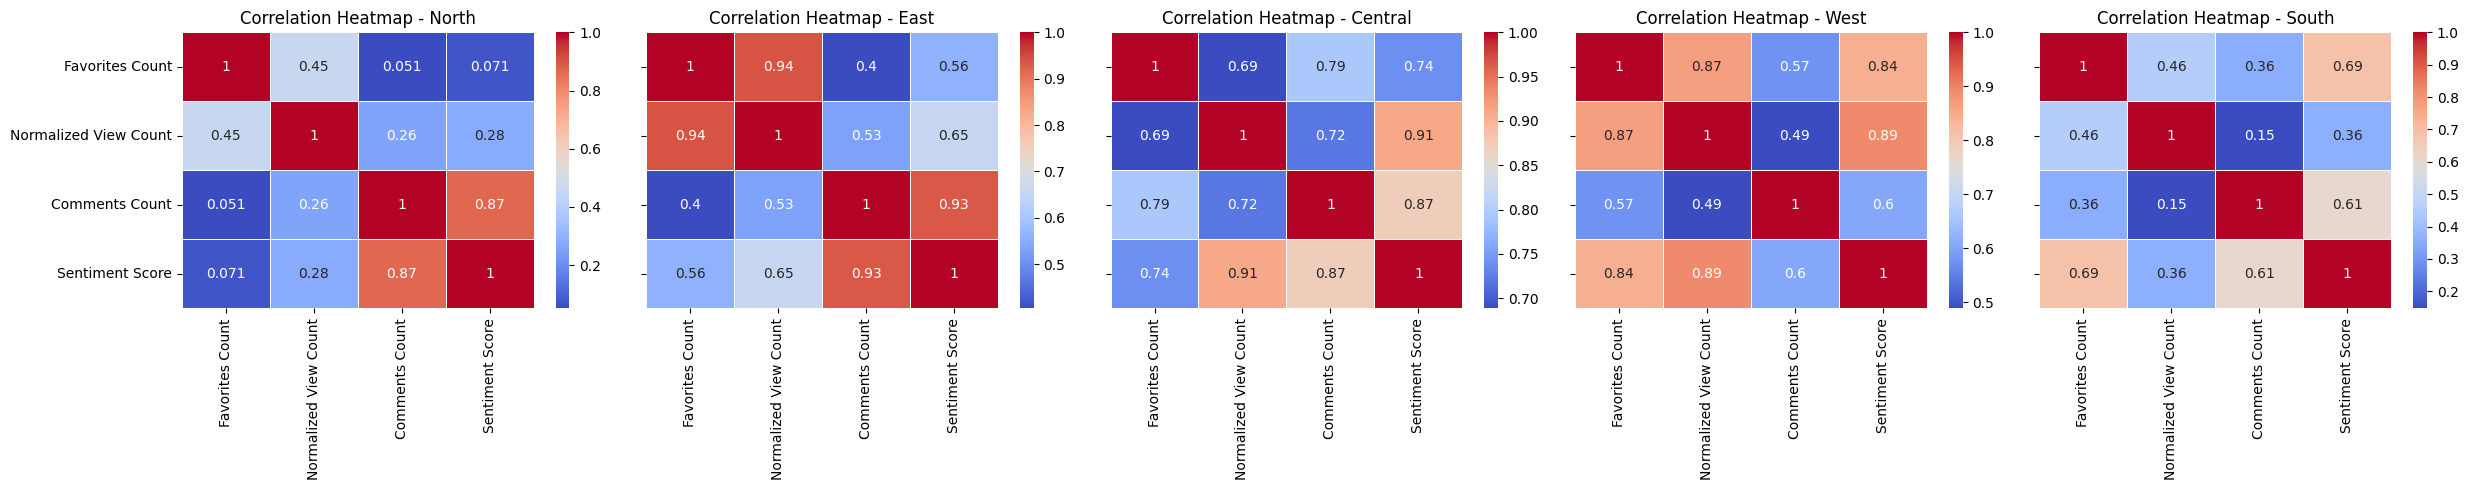

In [ ]:
# Load dataset
Afaq_processed = pd.read_csv("Afaq_Processed.csv")

# Define region mapping (ensure it matches dataset values)
region_mapping = {0: "North", 1: "South", 2: "Central", 3: "East", 4: "West"}
Afaq_processed["Region"] = Afaq_processed["Region"].map(region_mapping)

# Define numerical columns for correlation analysis
numeric_columns = [
    "Favorites Count", "Normalized View Count", "Comments Count", "Sentiment Score", "Elements Count"
]

# Remove "Elements Count" from correlation if necessary
numeric_columns = [col for col in numeric_columns if col in Afaq_processed.columns and col != "Elements Count"]

# Ensure "Region" column exists
if "Region" not in Afaq_processed.columns:
    raise ValueError("Region column is missing from the dataset.")

# Get unique regions
regions = Afaq_processed["Region"].unique()

# Create subplots: One heatmap for each region
fig, axes = plt.subplots(1, len(regions), figsize=(5 * len(regions), 5), sharey=True)

# If only one region exists, make sure axes is a list for iteration
if len(regions) == 1:
    axes = [axes]

# Loop through each region and create a heatmap
for i, region in enumerate(regions):
    ax = axes[i]  # Select subplot
    region_data = Afaq_processed[Afaq_processed["Region"] == region]  # Filter data for region

    # Compute correlation matrix
    correlation_matrix = region_data[numeric_columns].corr()

    # Plot heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, ax=ax)

    # Set title
    ax.set_title(f"Correlation Heatmap - {region}")

# Adjust layout
plt.tight_layout()
plt.show()


Analysis:

Favorites Count & Normalized View Count

- Strongest in East (0.94) and West (0.87) → Higher views strongly correlate with more favorites.
- Moderate in Central (0.69) → While correlated, some content may gain favorites independently of views.
- Weaker in North (0.45) and South (0.46) → Other factors may influence favorites beyond view count.

Comments Count & Sentiment Score

- Strong correlation across all regions (0.87 - 0.93) → More comments generally contribute to a higher sentiment score, indicating positive engagement.

Favorites Count & Comments Count

- Higher in Central (0.79) and West (0.57) → More favorited content is also actively discussed in these regions.
- Lower in North (0.05) and South (0.36) → Some highly favorited images do not necessarily generate many discussions.


####Scatter Plot: Favorites Count vs Normalized View Count

These scatter plots visualize the relationship between Favorites Count and Normalized View Count for each region separately, allowing us to examine engagement trends across different areas.



Region: North - Correlation between Favorites Count and Normalized View Count: 0.45 (p-value: 0.0033)
Region: East - Correlation between Favorites Count and Normalized View Count: 0.94 (p-value: 0.0000)
Region: Central - Correlation between Favorites Count and Normalized View Count: 0.69 (p-value: 0.0000)
Region: West - Correlation between Favorites Count and Normalized View Count: 0.87 (p-value: 0.0000)
Region: South - Correlation between Favorites Count and Normalized View Count: 0.46 (p-value: 0.0030)


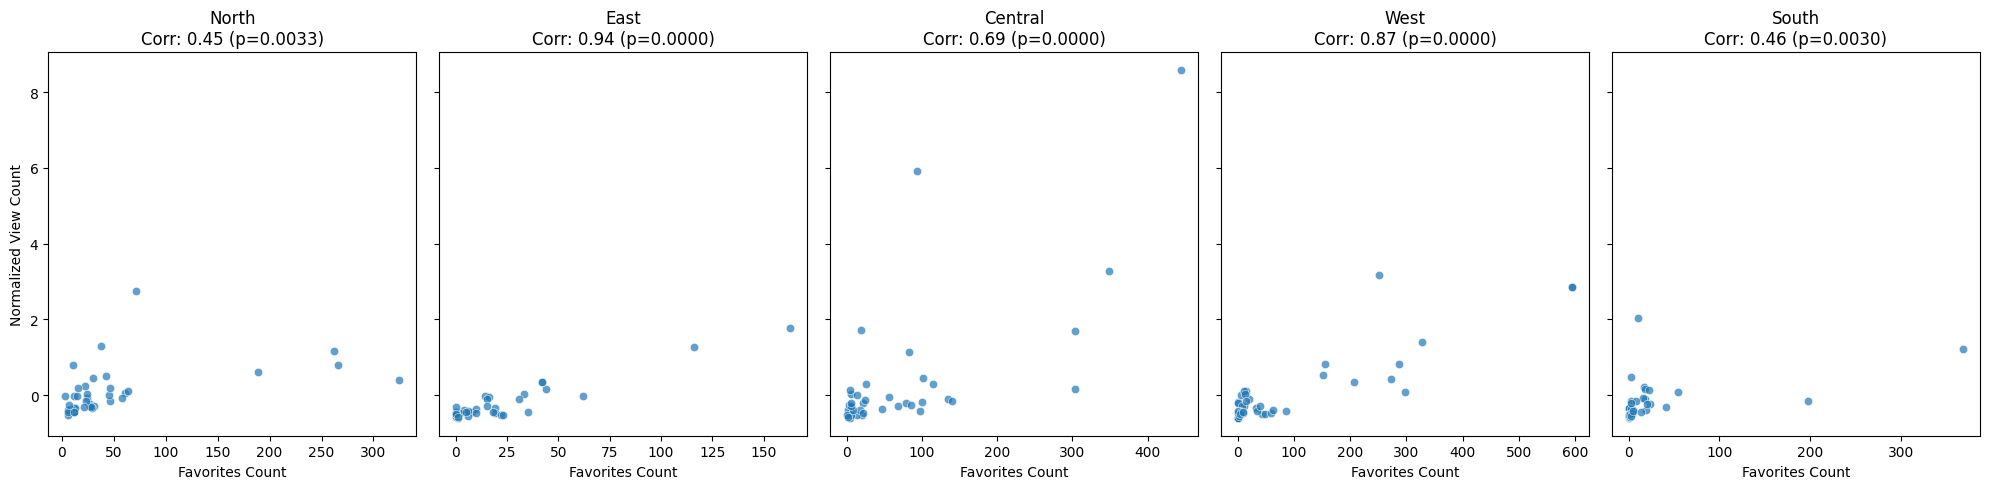

In [ ]:
Afaq_processed = pd.read_csv("Afaq_Processed.csv")

# Define region mapping (ensure it matches dataset values)
region_mapping = {0: "North", 1: "South", 2: "Central", 3: "East", 4: "West"}

# Map encoded regions to actual names and drop NaN values
Afaq_processed["Region"] = Afaq_processed["Region"].map(region_mapping)
Afaq_processed = Afaq_processed.dropna(subset=["Region"])  # Remove any unmapped values

# Define variables for correlation analysis
var1 = "Favorites Count"
var2 = "Normalized View Count"

# Get unique regions
regions = Afaq_processed["Region"].unique()

# Create a figure with 5 subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)  # 1 row, 5 columns

# Loop through each region, calculate correlation, and create scatter plots
for i, region in enumerate(regions):
    ax = axes[i]  # Select subplot
    region_data = Afaq_processed[Afaq_processed["Region"] == region]  # Filter data for region

    # Ensure the region has at least 2 data points before computing correlation
    if len(region_data) >= 2:
        correlation, p_value = pearsonr(region_data[var1], region_data[var2])
        title = f"{region}\nCorr: {correlation:.2f} (p={p_value:.4f})"
        print(f"Region: {region} - Correlation between {var1} and {var2}: {correlation:.2f} (p-value: {p_value:.4f})")
    else:
        title = f"{region}\nNot enough data"
        print(f"Region: {region} - Not enough data to calculate correlation.")

    # Create scatter plot
    sns.scatterplot(x=region_data[var1], y=region_data[var2], alpha=0.7, ax=ax)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



**Analysis:**

- There is a general positive correlation in all regions, indicating that images with more views tend to receive more favorites.
- East (0.94) and West (0.87) show strong positive correlations, suggesting that in these regions, high view counts are strongly associated with more favorites.
- Central (0.69) also has a moderate to strong correlation, but with more variability.
- North (0.45) and South (0.46) have weaker correlations, indicating that in these regions, some images gain favorites regardless of view count.
- Clusters of low-view, low-favorite images appear in all regions, suggesting a common distribution where most content receives limited engagement.
- Outliers are present, especially in the Central and West regions, where some images have high favorites despite lower views, indicating potentially viral content.


####Chi-Square Heatmap: Region vs Landscape Type

This heatmap visualizes the relationship between Region and Landscape Type, using a Chi-Square test to determine if there is a significant association between them.




Chi-Square Statistic: 73.87
P-Value: 0.0000
Degrees of Freedom: 16
Conclusion: There is a statistically significant association between Region and Landscape Type.


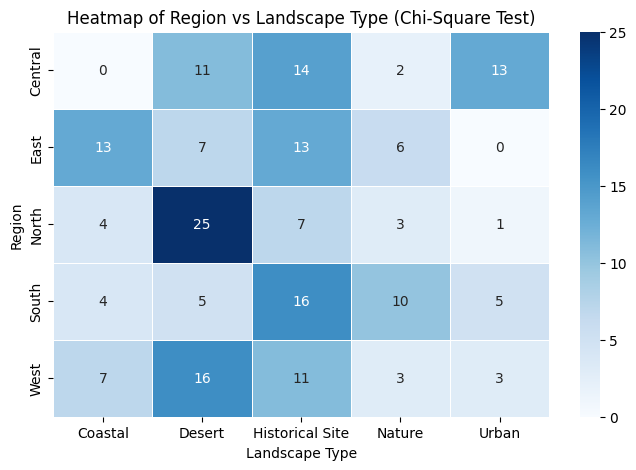

In [ ]:
# Define region mapping (ensure it matches dataset values)
landscape_mapping = {
    0: "Coastal",
    1: "Urban",
    2: "Historical Site",
    3: "Nature",
    4: "Desert" }
Afaq_processed["Landscape Type"] = Afaq_processed["Landscape Type"].map(landscape_mapping)

# Create a contingency table for "Region" and "Landscape Type"
contingency_table = pd.crosstab(Afaq_processed["Region"], Afaq_processed["Landscape Type"])

# Perform Chi-Square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

# Interpretation based on p-value
if p_value < 0.05:
    print("Conclusion: There is a statistically significant association between Region and Landscape Type.")
else:
    print("Conclusion: No significant association found between Region and Landscape Type.")


# Visualizing contingency table with heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
plt.title("Heatmap of Region vs Landscape Type (Chi-Square Test)")
plt.xlabel("Landscape Type")
plt.ylabel("Region")
plt.show()

**Analysis:**
- Central Region:

  The Central region has the highest count in Historical Sites (14 occurrences) and Urban areas (13 occurrences).
  This suggests that the Central region is more urbanized and historically significant rather than being a natural or coastal area.
- East Region:

	The highest count is for Coastal areas (13 occurrences), which implies a significant coastline.
	Historical sites (13 occurrences) are also prominent, indicating the presence of cultural or heritage locations.
	This suggests that the East is a coastal and historically rich region with limited desert or natural landscapes.
- North Region:

	The dominant landscape is Desert (25 occurrences), making it the region with the most desert coverage.
	This suggests that the North is predominantly desertous and sparsely urbanized, with limited access to coastal and urbanized landscapes.
- South Region:

	The South region has a high number of Nature landscapes (10 occurrences), making it the most nature-rich region.
	It also has a significant number of Historical Sites (16 occurrences), implying cultural or heritage importance.
	This suggests that the South has a diverse landscape, but with a strong presence of natural and historical sites.
- West Region:

	The Desert landscape (16 occurrences) is the most dominant in this region.
	Historical Sites (11 occurrences) and Coastal areas (7 occurrences) are also present but less prominent.
	This implies that the West is mostly desert with some coastal and historical significance but lacks urbanization and natural greenery.

#### Line Plot: Trend of Favorites Count Over Time

The following line charts display the trend of Favorites Count over time for each region. The analysis below highlights key patterns and differences in engagement across different areas



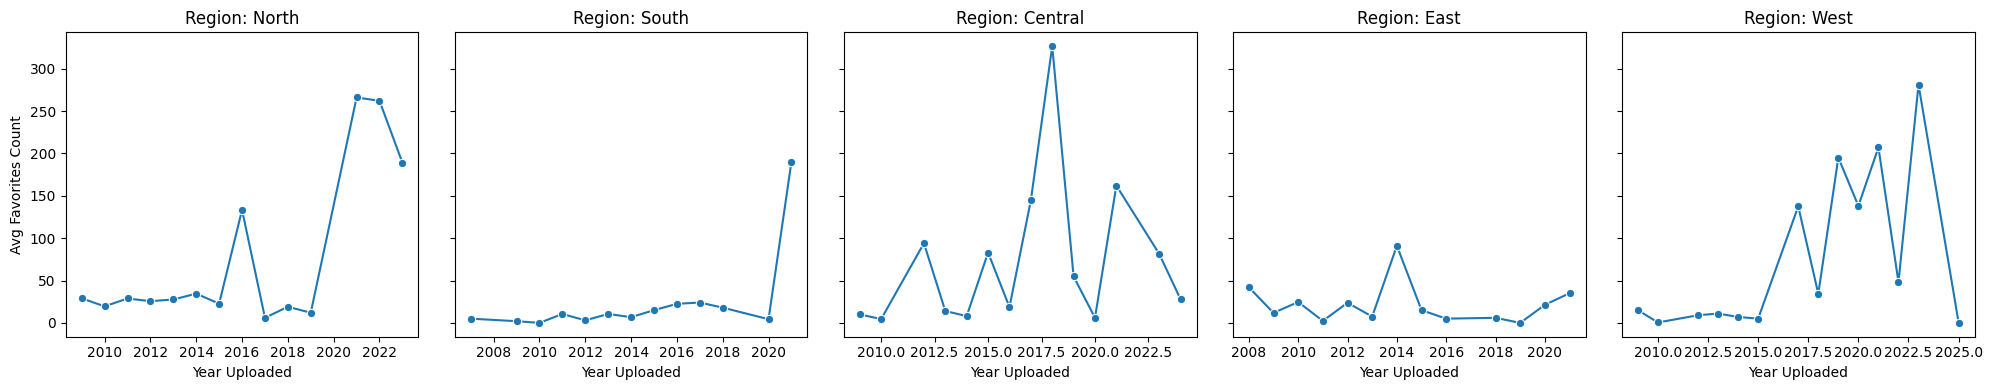

In [ ]:
Afaq_processed = pd.read_csv("Afaq_Processed.csv")

# Define region mapping (assuming numerical encoding)
region_mapping = {0: "North", 1: "South", 2: "Central", 3: "East", 4: "West"}

# Convert 'Date Uploaded' to Year format
Afaq_processed["Year Uploaded"] = pd.to_datetime(Afaq_processed["Date Uploaded"]).dt.year

# Group by Region and Year, then calculate the average favorites count
df_yearly_region = Afaq_processed.groupby(["Region", "Year Uploaded"])["Favorites Count"].mean().reset_index()

# Map region numbers to their actual names
df_yearly_region["Region"] = df_yearly_region["Region"].map(region_mapping)

# Get unique region names
regions = df_yearly_region["Region"].unique()

# Create a figure with 5 subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # 1 row, 5 columns

# Loop through each region and create a line plot
for i, region in enumerate(regions):
    ax = axes[i]  # Select subplot
    region_data = df_yearly_region[df_yearly_region["Region"] == region]  # Filter data for region

    # Create line plot
    sns.lineplot(x=region_data["Year Uploaded"], y=region_data["Favorites Count"], marker="o", linestyle="-", ax=ax)

    # Set title and labels
    ax.set_title(f"Region: {region}")  # Displays region name instead of number
    ax.set_xlabel("Year Uploaded")
    ax.set_ylabel("Avg Favorites Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



**Analysis:**

- Engagement remained low until 2015, followed by a gradual increase in most regions.
- A significant rise occurred around 2020–2022, with peaks in the North, South, and West regions.
- The Central region showed more fluctuations, while the East remained relatively steady with lower engagement.
- A decline after 2022 is observed across multiple regions, likely due to changes in user behavior, platform trends, or dataset limitations.


### Visualisation

This bar chart presents the Popularity Score for different regions. It helps identify which regions receive the highest engagement from visitors, providing insights into the most popular tourist destinations.

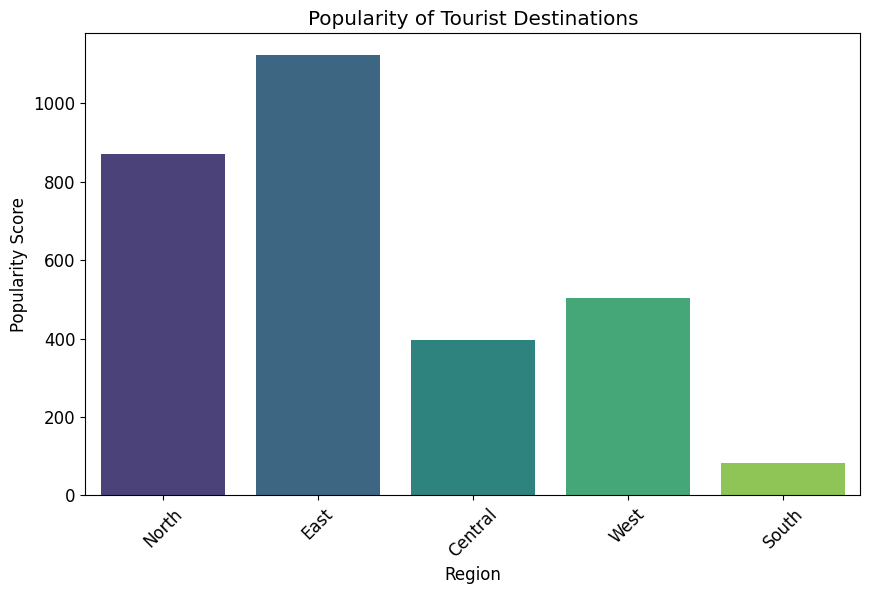

In [ ]:
file_path = "Afaq_EDA.csv"
df = pd.read_csv(file_path)

warnings.simplefilter(action='ignore', category=FutureWarning)

region_mapping = {0: "North", 1: "South", 2: "Central", 3: "East", 4: "West"}
df["Region"] = df["Region"].map(region_mapping)
plt.rcParams.update({'font.size': 12})
regions = df["Region"].unique()


plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Region", y="Popularity Score", ci=None, palette="viridis")
plt.title("Popularity of Tourist Destinations")
plt.xlabel("Region")
plt.ylabel("Popularity Score")
plt.xticks(rotation=45)
plt.show()

**Analysis:**

* Eastern Region (East): This region ranks highest in popularity, suggesting
that it attracts the most attention from visitors, likely due to a combination of engaging content, strong emotional sentiment, and high interaction (likes, comments, favorites).

* Northern Region (North): Comes in second, indicating substantial tourist interest. It suggests that the region’s offerings—such as historical landmarks or natural beauty—generate a high level of positive engagement.

* Western Region (West): Though traditionally popular, it now ranks third based on popularity score. This could imply either lower engagement relative to expectations or less emotional connection in visitor responses.

* Central Region (Central): With a moderate popularity score, it may attract tourists but with less interaction or positive sentiment than the top regions.

* Southern Region (South): Ranked lowest, indicating limited visitor engagement and potentially a lack of standout attractions or online presence in the dataset.








Since the South region had the lowest engagement overall, we visualized the top-performing photos from both South and Central regions to better understand and highlight their performance.

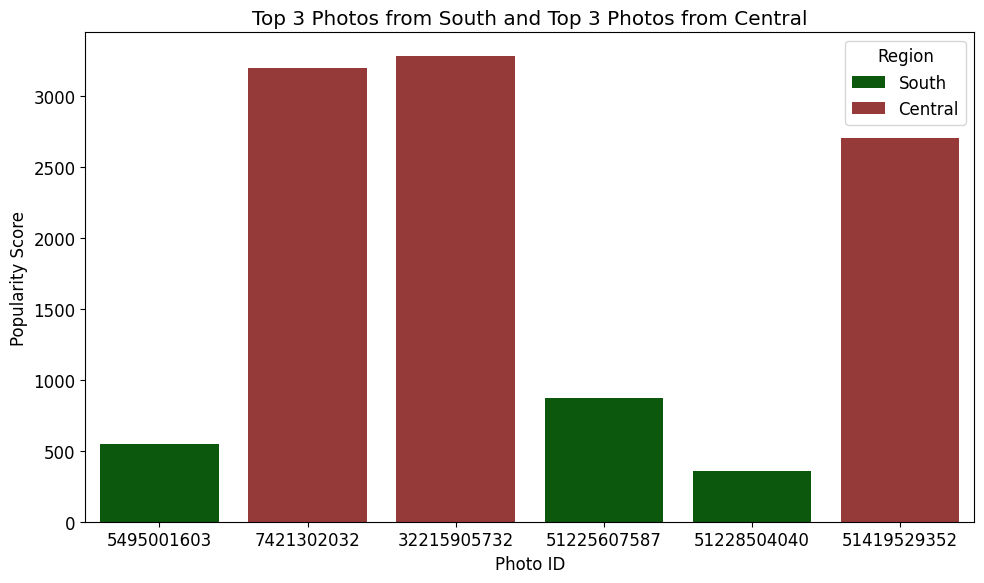

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
AfaqEDA = pd.read_csv("Afaq_EDA.csv")

# Map region codes to names
region_mapping = {0: "North", 1: "South", 2: "Central", 3: "East", 4: "West"}
AfaqEDA['Region'] = AfaqEDA['Region'].map(region_mapping)

# Filter separately
south_data = AfaqEDA[AfaqEDA['Region'] == 'South']
central_data = AfaqEDA[AfaqEDA['Region'] == 'Central']

# Get top 3 from South and top 3 from Central
top_3_south = south_data.sort_values(by='Popularity Score', ascending=False).head(3)
top_3_central = central_data.sort_values(by='Popularity Score', ascending=False).head(3)

# Combine them
top_6 = pd.concat([top_3_south, top_3_central])

# Convert Popularity Score to integer
top_6['Popularity Score'] = top_6['Popularity Score'].astype(int)

# Define custom colors
custom_palette = {
    'South': 'darkgreen',
    'Central': 'brown'
}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_6,
    x='Photo ID',
    y='Popularity Score',
    hue='Region',
    palette=custom_palette
)
plt.title('Top 3 Photos from South and Top 3 Photos from Central')
plt.xlabel('Photo ID')
plt.ylabel('Popularity Score')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

Since the South region showed the lowest engagement compared to other regions, we believe it deserves more strategic attention and promotion. Enhancing visibility for the South can help achieve a better balance across regions and encourage more interest and interaction from the audience.

This violin plot illustrates the distribution of Popularity Score across the four seasons in the North, East, Central, West, and South regions. The width of each season's distribution indicates the spread of the data—wider areas represent higher variation in views, while narrower sections suggest more consistent engagement.

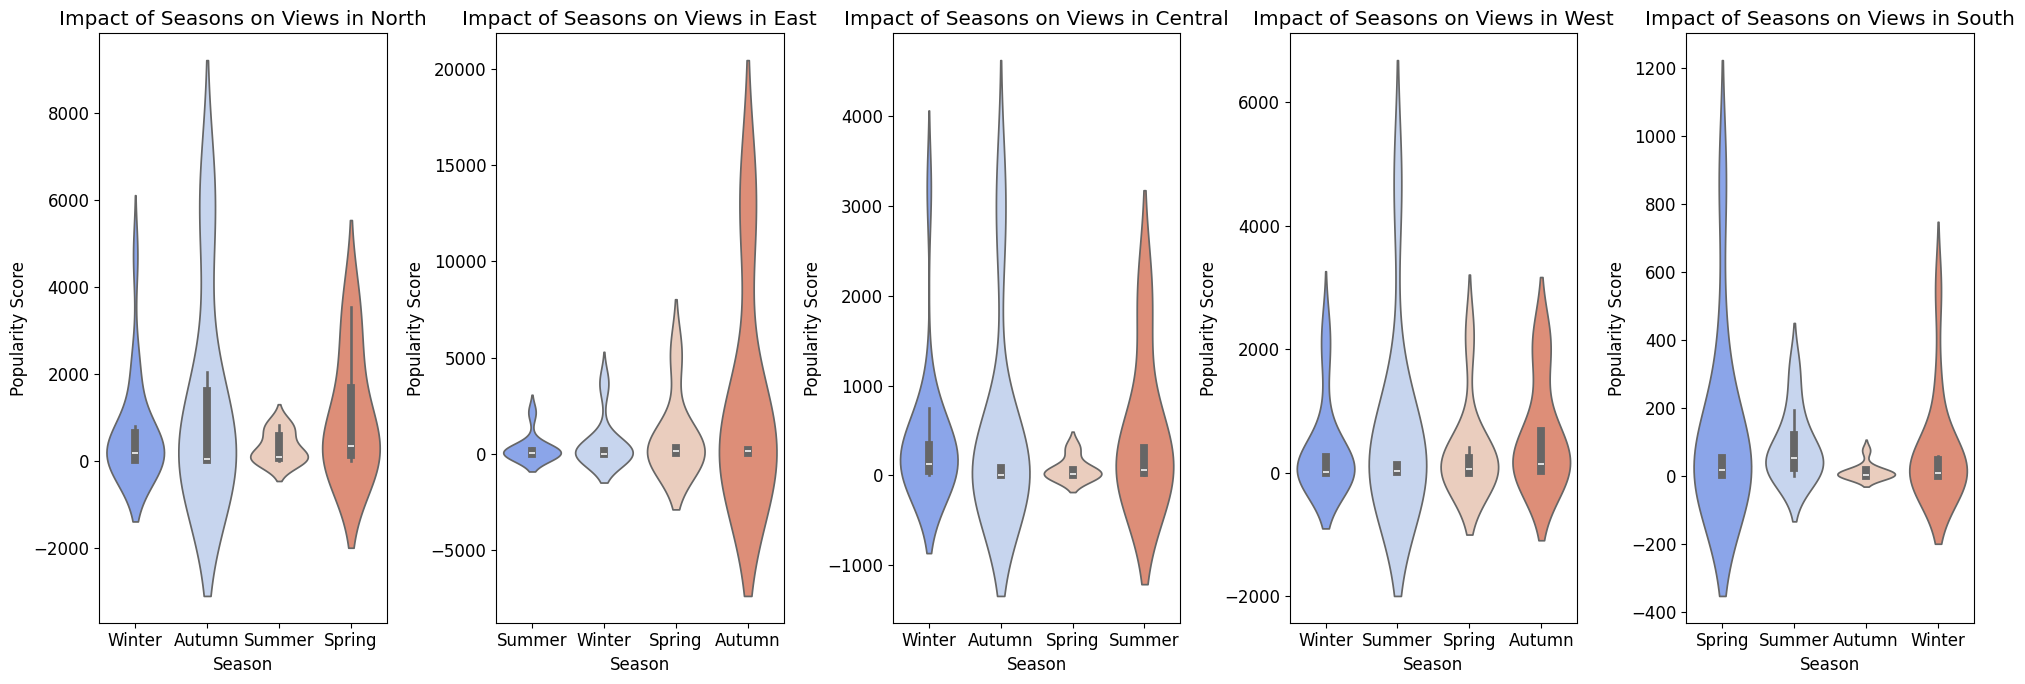

In [ ]:
# Ensure the 'Season' column is properly mapped before visualization
season_mapping = { 1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn" }
df["Season"] = df["Season"].map(season_mapping)  # Apply mapping
plt.figure(figsize=(20, 7))
for i, region in enumerate(regions, 1):
    plt.subplot(1, len(regions), i)  # Single row layout
    sns.violinplot(data=df[df["Region"] == region], x="Season", y="Popularity Score", palette="coolwarm")
    plt.title(f"Impact of Seasons on Views in {region}")
    plt.xlabel("Season")
    plt.ylabel("Popularity Score")
plt.tight_layout()
plt.show()

**Analysis:**

* Northern Region:
Autumn has the highest popularity score, showing strong engagement during this season. Winter follows with high variation, indicating fluctuating interaction. Summer and Spring show lower and more stable scores.

* Eastern Region:
Autumn again stands out with the highest popularity, showing intense engagement and wide distribution. Spring also shows noticeable popularity. Winter and Summer have the lowest and most consistent scores.

* Central Region:
Winter shows the most variation, while Autumn has slightly more consistent and higher scores. Spring and Summer are less active, with lower popularity scores and narrower spreads.

* Western Region:
Autumn records the most variation and peak scores, suggesting strong but uneven engagement. Winter follows with stable performance. Spring and Summer are less popular and more consistent.

* Southern Region:
Spring is the most engaging season with the highest median and spread in popularity scores. Summer also has moderate popularity. Winter and Autumn are the least popular and most stable.



This box plot displays the distribution of popularity score throughout different times of the day. It helps determine the time periods when photos receive the highest engagement, providing insights into visitor activity patterns.

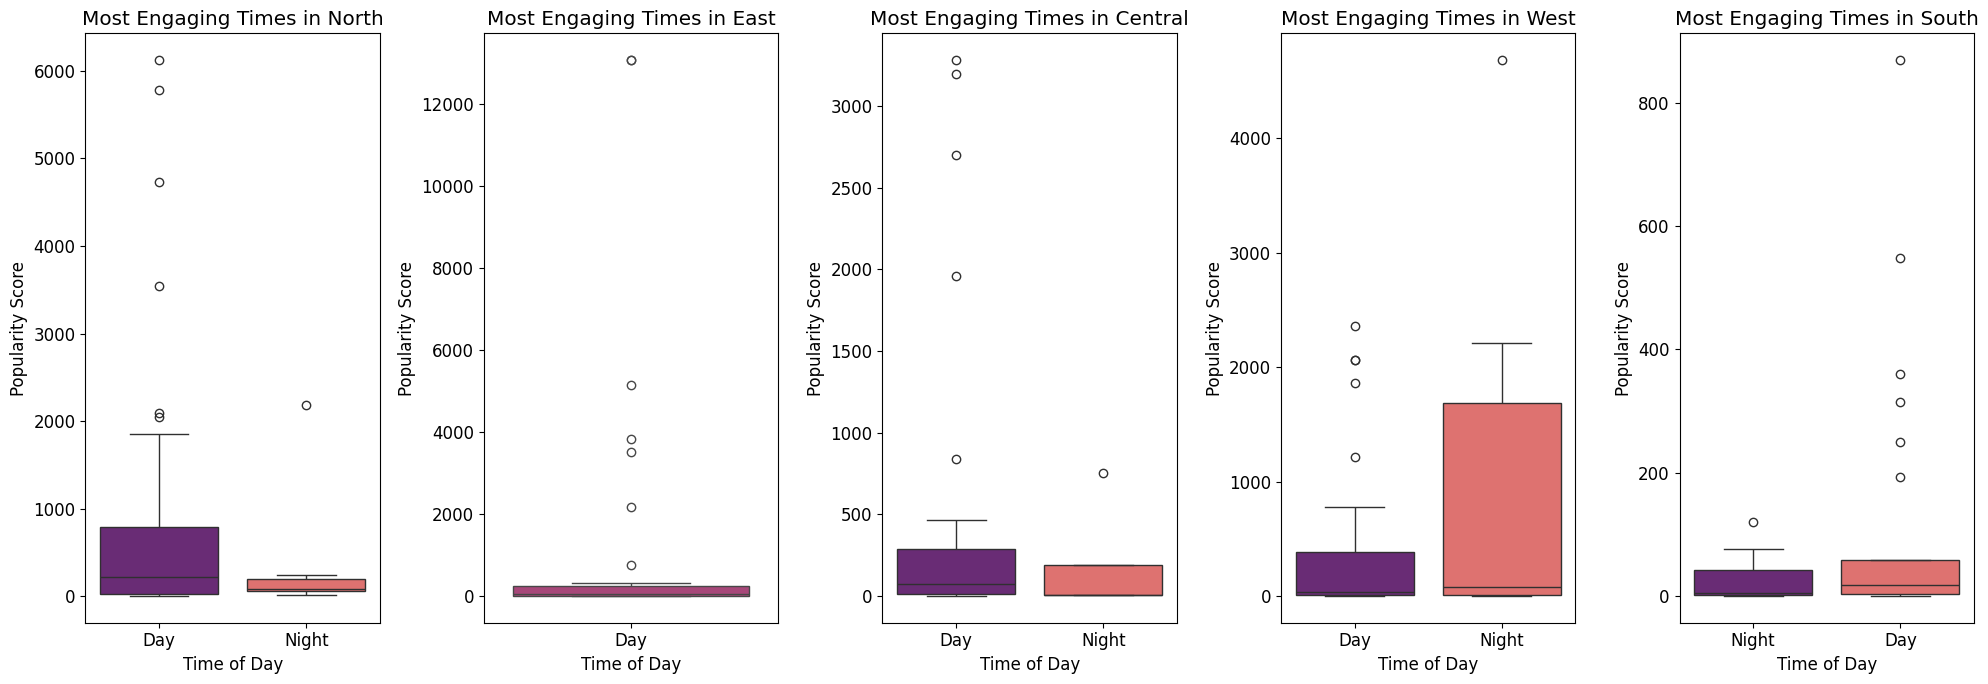

In [ ]:
# Ensure the 'Time of Day' column is properly mapped before visualization
time_mapping = { 0: "Day", 1: "Night"}
df["Time of Day"] = df["Time of Day"].map(time_mapping)  # Apply mapping
plt.figure(figsize=(20, 7))
for i, region in enumerate(regions, 1):
    plt.subplot(1, len(regions), i)  # Single row layout
    sns.boxplot(data=df[df["Region"] == region], x="Time of Day", y="Popularity Score", palette="magma")
    plt.title(f"Most Engaging Times in {region}")
    plt.xlabel("Time of Day")
    plt.ylabel("Popularity Score")
plt.tight_layout()
plt.show()

**Analysis:**

- Northern Region:
Daytime shows higher popularity scores overall, with greater variation and higher medians, suggesting that tourist engagement is significantly stronger during the day.

- Eastern Region :
Daytime clearly leads with the highest popularity scores and extreme outliers, confirming that tourists are more active and engaged during daylight hours in this region.

- Central Region:
Day and night show similar distributions, with no drastic difference, indicating that engagement is relatively balanced and time of day does not strongly impact popularity in this region.

- Western Region:
Nighttime receives significantly higher engagement than daytime. The median popularity score is much greater at night. This suggests that tourists engage more with photos taken at night.

- Southern Region :
Daytime slightly outperforms nighttime in terms of both median and spread of popularity scores. Although both are relatively low overall.

This bar plot illustrates the most frequently appearing visual elements in photos taken in each region. It provides insights into dominant themes in tourism photography, such as landmarks, natural landscapes, or urban elements.

The following code splits and explodes the visual elements from each photo, then calculates the average popularity score for each element. This helps identify which features are most common in high-engagement tourism images.

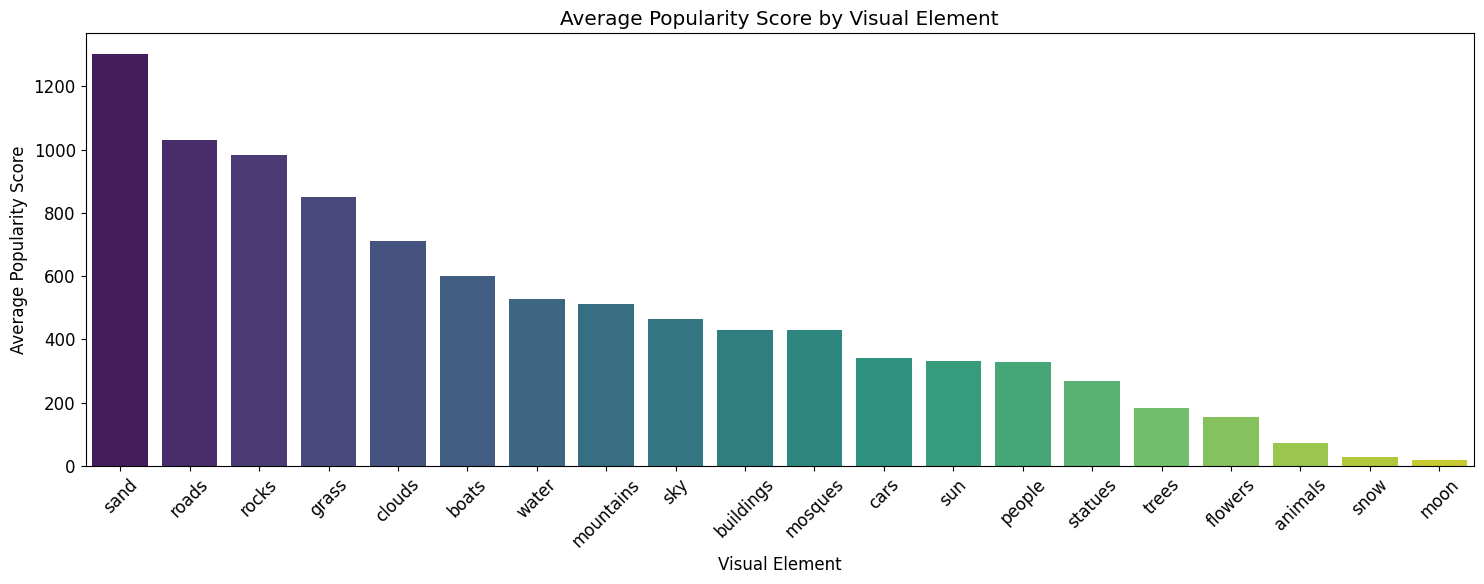

In [ ]:
# First, explode the visual elements so each one has its own row
df= df.dropna(subset=["Visual Elements"]).copy()
df["Visual Elements"] = df["Visual Elements"].str.split(", ")
df= df.explode("Visual Elements")

# Then, group by visual element and calculate average popularity score
popularity_by_element = df.groupby("Visual Elements")["Popularity Score"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(x=popularity_by_element.index, y=popularity_by_element.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Average Popularity Score by Visual Element")
plt.xlabel("Visual Element")
plt.ylabel("Average Popularity Score")
plt.tight_layout()
plt.show()


The bar plot highlights which visual elements are most associated with popular photos. Elements like sand, roads, and rocks consistently had higher average popularity scores, suggesting they are visually appealing to viewers.

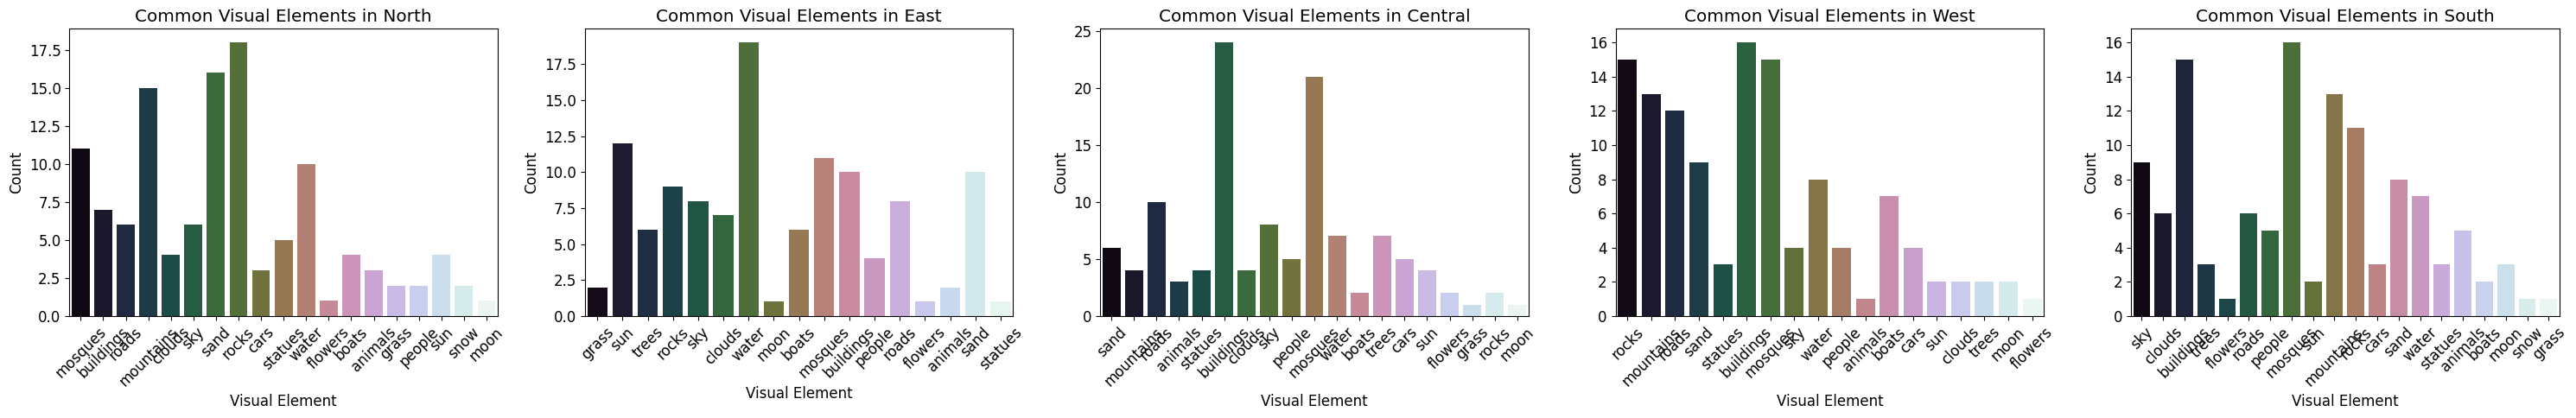

In [ ]:
plt.figure(figsize=(30, 5))
for i, region in enumerate(regions, 1):
    plt.subplot(1, len(regions), i)  # Single row layout
    region_df = df[df["Region"] == region]
    visual_elements = ", ".join(region_df["Visual Elements"].dropna().tolist()).split(", ")
    visual_counts = Counter(visual_elements)
    sns.barplot(x=list(visual_counts.keys()), y=list(visual_counts.values()), palette="cubehelix")
    plt.title(f"Common Visual Elements in {region}")
    plt.xlabel("Visual Element")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Analysis:**

* Western Region (West): Contains a high percentage of buildings, mosques and rocks, indicating that tourists are primarily interested in cultural and heritage-related experiences.
* Northern Region (North): Natural elements such as mountains, sand, and rock formations are most frequently captured, reflecting tourists’ interest in adventure and nature exploration.
* Central Region (Central): Features images of modern infrastructure and buildings, indicating that tourism is centered around urban activities and commercial areas.
* Eastern Region (East): Shows a dominance of coastal landscapes, confirming that tourism is mainly centered around marine activities.
* Southern Region (South): Characterized by mosques, buildings and mountain landscapes, with frequent images of rocks and sky, highlighting its role as a prime destination for desert exploration.

## Modeling Task

#### Converting Date Uploaded to Year only
We converted the 'Date Uploaded' column to extract only the year, simplifying the feature for analysis by focusing on the time frame without detailed timestamps.

In [ ]:
Afaq_Processed = pd.read_csv("Afaq_EDA.csv")

# Convert Date Uploaded to Year only
Afaq_Processed['Date Uploaded'] = pd.to_datetime(Afaq_processed['Date Uploaded']).dt.year

#### Encoding Visual Elements for Modeling
The Visual Elements column contained comma-separated text describing objects in each photo. Since regression models require numerical inputs, we transformed this column into multiple binary (0/1) features — one for each unique element. This was done using one-hot encoding, allowing the model to learn the impact of specific visual components on popularity score.

In [ ]:
    # Step 1: Replace NaNs with empty string to avoid errors
    Afaq_Processed['Visual Elements'] = Afaq_Processed['Visual Elements'].fillna('')

    # Step 2: Convert comma-separated strings into dummy variables
    visual_dummies = Afaq_Processed['Visual Elements'].str.get_dummies(sep=', ')

    # Step 3: Merge with the original DataFrame and drop the original column
    Afaq_Processed = pd.concat([Afaq_Processed.drop('Visual Elements', axis=1), visual_dummies], axis=1)

#### Data Split
Splitting the Dataset into Training and Testing Sets
To evaluate the model’s performance on unseen data, we split the dataset into features (X) and target (Popularity Score), then divided it into training and testing sets using an 80/20 ratio. This common practice allocates 80% of the data for training the model and 20% for testing, ensuring the model learns effectively while still allowing for reliable evaluation.

In [ ]:
# Define features and target
X = Afaq_Processed.drop('Popularity Score', axis=1)
y = Afaq_Processed['Popularity Score']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Modeling building
We selected three different regression models to cover a range of complexities and learning capabilities. Linear Regression was chosen as a baseline due to its simplicity and interpretability, providing a reference point for more advanced models. Random Forest Regressor was included for its ability to capture non-linear relationships and handle high-dimensional data effectively. Support Vector Regressor (SVR) was selected to evaluate how a margin-based, kernel-capable model performs on our dataset, particularly in capturing subtle patterns that linear models might miss. This combination allowed us to compare performance across simple, ensemble-based, and kernel-based approaches.

##### Linear Regression (Baseline Model)
We begin by training a baseline Linear Regression model to serve as a benchmark. We evaluate its performance using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score.



In [ ]:
# Train baseline Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Calculate R² and Adjusted R²
r2 = metrics.r2_score(y_test, y_pred_lr)

n = X_test.shape[0]  # number of testing samples
k = X_test.shape[1]  # number of predictors (features)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Print evaluation metrics
print("\nLinear Regression:")
print("MAE:", metrics.mean_absolute_error(y_test, y_pred_lr))
print("MSE:", metrics.mean_squared_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')
print('Accuracy: {:.2f}'.format(lr.score(X_test, y_test)))


Linear Regression:
MAE: 412.15233397682186
MSE: 577233.0584213503
RMSE: 759.7585527135251
R-squared: 0.8755112956564208
Adjusted R-squared: 0.3064200758000589
Accuracy: 0.88


##### Random Forest Regressor
Next, we train a Random Forest Regressor, which is an ensemble learning method known for reducing variance and improving accuracy. We evaluate its performance using the same metrics.

In [ ]:
# Train the Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Calculate R² and Adjusted R²
r2 = metrics.r2_score(y_test, y_pred_rf)

n = X_test.shape[0]  # number of testing samples
k = X_test.shape[1]  # number of predictors (features)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Print evaluation metrics
print("\nRandom Forest:")
print("MAE:", metrics.mean_absolute_error(y_test, y_pred_rf))
print("MSE:", metrics.mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')
print('Accuracy: {:.2f}'.format(rf.score(X_test, y_test)))


Random Forest:
MAE: 179.34898488552454
MSE: 311158.32003755216
RMSE: 557.8156685120562
R-squared: 0.9328941827879086
Adjusted R-squared: 0.6261247326754907
Accuracy: 0.93


##### Support Vector Regressor (SVR)
Lastly, we train a Support Vector Regressor, which is effective in capturing complex relationships in smaller datasets. The model’s performance is assessed using MAE, MSE, and R² score.

In [ ]:
# Train Support Vector Regressor model
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Calculate R² and Adjusted R²
r2 = metrics.r2_score(y_test, y_pred_svr)

n = X_test.shape[0]  # number of testing samples
k = X_test.shape[1]  # number of predictors (features)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Print evaluation metrics
print("\nSupport Vector Regressor:")
print("MAE:", metrics.mean_absolute_error(y_test, y_pred_svr))
print("MSE:", metrics.mean_squared_error(y_test, y_pred_svr))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))
print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')
print('Accuracy: {:.2f}'.format(svr.score(X_test, y_test)))


Support Vector Regressor:
MAE: 715.1547392277015
MSE: 5071088.036239889
RMSE: 2251.907643807776
R-squared: -0.09365388907250982
Adjusted R-squared: -5.093214524832555
Accuracy: -0.09


#### Best-Performing Model

Among the three regression models tested —Linear Regression, Random Forest, and Support Vector Regressor—the **Random Forest Regressor** demonstrated the best performance.

It achieved the lowest Mean Absolute Error (MAE: 180), the lowest Mean Squared Error (MSE: 312,259.98), and the highest R² Score (0.93) with an accuracy of 93%, indicating it explains over 93% of the variance in the popularity score. Therefore, Random Forest was selected as the final model for prediction.

We visualized the results by plotting actual vs. predicted scores for each model. The comparison clearly showed that Random Forest delivered the most accurate predictions, with points closely aligned to the ideal diagonal. On the other hand, Linear Regression and SVR exhibited more scattered predictions and lower performance.

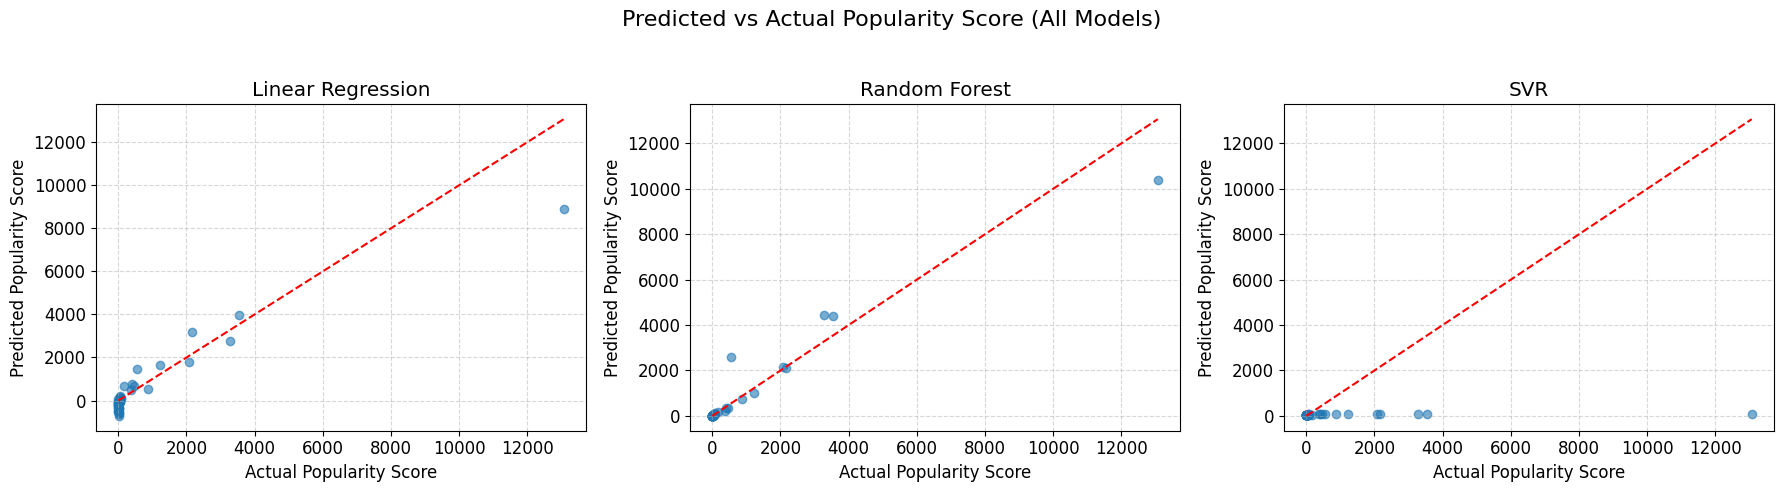

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


X = Afaq_Processed.drop(columns=[
    "Photo ID", "Date Uploaded", "Visual Elements", "Popularity Score"
], errors='ignore')
y = Afaq_Processed["Popularity Score"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
svr = SVR()

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
svr.fit(X_train, y_train)


y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svr = svr.predict(X_test)


y_test_array = y_test.to_numpy()
preds = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, y_pred) in zip(axs, preds.items()):
    ax.scatter(y_test_array, y_pred, alpha=0.6)
    ax.plot([y_test_array.min(), y_test_array.max()],
            [y_test_array.min(), y_test_array.max()], 'r--')
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Actual Popularity Score")
    ax.set_ylabel("Predicted Popularity Score")
    ax.grid(True, linestyle='--', alpha=0.5)

fig.suptitle("Predicted vs Actual Popularity Score (All Models)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

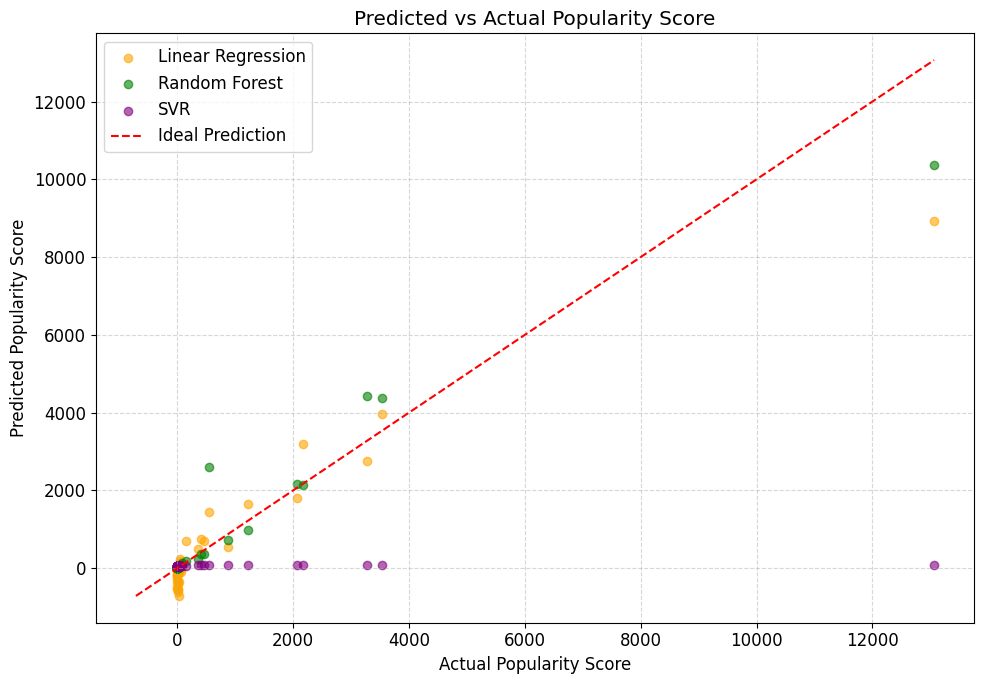

In [ ]:
import matplotlib.pyplot as plt

# Convert y_test to a NumPy array
y_test_array = y_test.to_numpy()

# Create the figure
plt.figure(figsize=(10, 7))

# Define model predictions and colors
model_preds = {
    "Linear Regression": (y_pred_lr, 'orange'),
    "Random Forest": (y_pred_rf, 'green'),
    "SVR": (y_pred_svr, 'purple')
}

# Plot predictions for each model
for model_name, (y_pred, color) in model_preds.items():
    plt.scatter(y_test_array, y_pred, label=model_name, alpha=0.6, color=color)

# Plot the y = x reference line
min_val = min(y_test_array.min(), min(y_pred_lr.min(), y_pred_rf.min(), y_pred_svr.min()))
max_val = max(y_test_array.max(), max(y_pred_lr.max(), y_pred_rf.max(), y_pred_svr.max()))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

# Labels and title
plt.title("Predicted vs Actual Popularity Score")
plt.xlabel("Actual Popularity Score")
plt.ylabel("Predicted Popularity Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


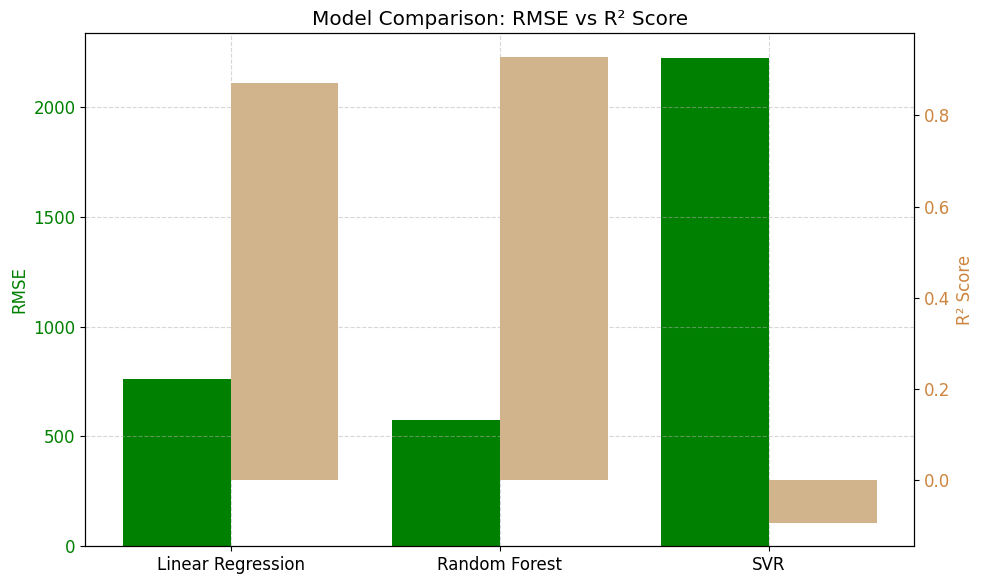

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Linear Regression', 'Random Forest', 'SVR']
rmse = [759.75, 576.70, 2223.83]
r2 = [0.8702, 0.9288, -0.0939]

x = np.arange(len(models))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Y-axis: RMSE
bar1 = ax1.bar(x - width/2, rmse, width, label='RMSE', color='green')
ax1.set_ylabel('RMSE', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Secondary Y-axis: R² Score
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2, width, label='R² Score', color='#D2B48C')
ax2.set_ylabel('R² Score', color='#CD853F')
ax2.tick_params(axis='y', labelcolor='#CD853F')

# X-axis and titles
ax1.set_xticks(x)
ax1.set_xticklabels(models)
plt.title('Model Comparison: RMSE vs R² Score')

# Add grid to main axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Show plot
fig.tight_layout()
plt.show()


## Results and Findings

This code displays the fetched data that we believe will be instrumental in our analysis. By reviewing this information, we can gain insights into the characteristics of the selected photos and their potential influence on tourism in Saudi Arabia.

In [ ]:
# Process each photo ID and display the required details
for region_name, photo_list in photo_ids.items():
    for photo_id in photo_list:  # Iterate through each photo ID in the region
        photo_details = get_photo_details(api_key, photo_id)
        if isinstance(photo_details, tuple):
            image_url, title, views, favorites_count, comments_count, comments, date_uploaded, date_taken = photo_details

            # Extract visual elements and region type
            region = get_region(photo_id)  # Get the region for the photo ID
            landscape_type = classify_region(image_url)  # Passing the image_url from photo_details
            # Initialize viewsList inside the loop
            viewsList = []  # Create an empty list to store view counts
            viewsList.append(int(views))  # Add the current photo's views to the list
            # Extract visual elements from the image
            visual_elements = extract_visual_elements(image_url)  # Call the function to get visual elements

            element_count = count_total_visual_elements(image_url)  # Count the total visual elements

            # Classify each comment and store the results
            classified_comments = [classify_comments(comment) for comment in comments]

            # Calculate sentiment score based on classified comments
            sentiment_score = calculate_sentiment_score(classified_comments)

            season = get_season(date_taken)

            time_of_day = classify_image_time_of_day(image_url)

            date_uploaded = standardize_date(date_uploaded)

            # Apply normalization
            normalized_views = normalize_views_zscore()
            normalized_value = normalized_views.get(photo_id, 0.0)  # Retrieve the normalized value

            print(f"Photo ID: {photo_id}")
            print(f"Title: {title}")
            print(f"Views: {normalized_value}")
            print(f"Comments: {comments_count}")
            print(f"Favorited by: {favorites_count} people")
            print(f"Sentiment Score: {sentiment_score}")  # Print the sentiment score
            print(f"Date Uploaded: {date_uploaded}")
            print(f"Season: {season}")
            print(f"Time of Day: {time_of_day}")
            print(f"Region: {region}")  # Print the photo ID as the location
            print(f"Visual Elements: {', '.join(visual_elements)}")  # Print the visual elements
            print(f"Elements Count: {element_count}")
            print(f"Landscape Type: {landscape_type}")
            print("\nDisplaying the image:\n")

            display_image(image_url)  # Display the image using the image_url from photo_details

#### Final  Data

The following code saves our final structured data into a dataset.

In [ ]:
Afaq_Processed.to_csv('Afaq_Structured.csv', index=False)

### Findings of Data Collection Phase:

- Engagement Variability: Engagement levels (favorites, views, and comments) varied significantly across photos. While some images had high interaction, others received minimal engagement, highlighting inconsistencies in user interest.
- Metadata Gaps: Some images had missing or incomplete metadata, which required adjustments in data extraction and filtering to ensure consistency in the dataset.
- Inconsistent  Data: Attributes such as titles, descriptions, and tags varied in detail and accuracy, making them unreliable as a primary source of data.
- API Limitations: Flickr’s rate limits influenced the data collection process, requiring optimizations to retrieve data efficiently without exceeding request restrictions.

### Findings of Data Processing and EDA Phase:

- Computational Cost of Image Processing: The processing phase took approximately 4 hours to complete, indicating a significant computational load for handling image data.

- Comparison Based on Region: After visualizing the data, we observed distinct patterns across different regions, confirming the necessity of a region-based analysis.

- Missing Image Issue: Although the array of IDs originally contains 200 photos, an image suddenly went missing during processing, reducing the total to 199 photos. Further investigation is required to determine the cause of this discrepancy.

- Daylight-Only Values in East Region: Our visualization revealed that the East region only contained daytime values, meaning no nighttime data was available for analysis in this region.

### Findings of Modeling and Communication Phase:

- Popularity Score Enabled Quantitative Prediction: We created a composite metric called Popularity Score by combining likes, views, and comments. This score served as the target variable for regression, enabling us to quantify and predict photo popularity using various visual and contextual features.

- Transforming Non-Numeric Features Enabled Modeling: We observed that converting Date Uploaded to timestamps and one-hot encoding Visual Elements was essential for compatibility with regression models and helped preserve meaningful temporal and visual information.

- 80/20 Split Was Sufficient for Reliable Evaluation: Using 80% of the data for training and 20% for testing provided a balanced setup that allowed effective learning while ensuring trustworthy evaluation of model performance.

- Random Forest Was the Most Effective Model: Random Forest outperformed other models with an R² of 0.93, showing it could capture complex patterns in the data and make highly accurate predictions.

- SVR Struggled With Dataset Complexity: Support Vector Regression had the weakest performance, with a negative R², suggesting it couldn’t handle the dataset’s structure or required additional preprocessing.

- Linear Regression Served as a Solid Baseline: Linear Regression performed reasonably well (R² = 0.87), confirming it could capture general trends, though it was less precise than Random Forest.